In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
from scipy import sparse


In [2]:
np.random.seed(401)

In [3]:
co_expressalog_map_85 = pd.read_csv('/data/passala/Generated_Tables/Maize_Rice_integration/true_pair_dataframe_default_settigns.csv')
co_expressalog_map_85

Rice Gene      Maize Gene
0     Os01g0195400  Zm00001d008850
1     Os05g0199100  Zm00001d037751
2     Os01g0101600  Zm00001d008390
3     Os01g0256800  Zm00001d008326
4     Os01g0847100  Zm00001d042875
...            ...             ...
7652      BAC19863   GRMZM5G898647
7653      BAC19893   GRMZM5G867512
7654      BAC19869   GRMZM5G861791
7655      BAC19875   GRMZM5G804358
7656      BAC19857   GRMZM5G890451

[7657 rows x 2 columns]

In [4]:
one_to_ones = pd.read_csv('/data/passala/Generated_Tables/Maize_Rice_integration/maize_rice_one_to_one.csv')
one_to_ones = one_to_ones[['maize','rice']]
one_to_ones = one_to_ones.rename(columns = {'maize':'Maize Gene','rice':'Rice Gene'})
one_to_ones['One to One'] = 'Yes'
one_to_ones

Maize Gene     Rice Gene One to One
0     Zm00001d008326  Os01g0256800        Yes
1     Zm00001d042875  Os01g0847100        Yes
2     Zm00001d039878  Os01g0144300        Yes
3     Zm00001d012590  Os01g0796400        Yes
4     Zm00001d042520  Os01g0897100        Yes
...              ...           ...        ...
5466   GRMZM5G839924      BAC19900        Yes
5467   GRMZM5G889905      BAC19903        Yes
5468  Zm00001d040880      BAC19899        Yes
5469   GRMZM5G890451      BAC19857        Yes
5470   GRMZM5G851130      BAC19874        Yes

[5471 rows x 3 columns]

In [5]:
#co_expressalog_map_85 = co_expressalog_map_85.merge(on = ['Maize Gene','Rice Gene'], right = one_to_ones, how = 'left')

In [6]:
co_expressalog_map_85 = co_expressalog_map_85.drop_duplicates(subset = 'Rice Gene')
co_expressalog_map_85 = co_expressalog_map_85.drop_duplicates(subset = 'Maize Gene')
co_expressalog_map_85

Rice Gene      Maize Gene
0     Os01g0195400  Zm00001d008850
1     Os05g0199100  Zm00001d037751
2     Os01g0101600  Zm00001d008390
3     Os01g0256800  Zm00001d008326
4     Os01g0847100  Zm00001d042875
...            ...             ...
7652      BAC19863   GRMZM5G898647
7653      BAC19893   GRMZM5G867512
7654      BAC19869   GRMZM5G861791
7655      BAC19875   GRMZM5G804358
7656      BAC19857   GRMZM5G890451

[7657 rows x 2 columns]

In [7]:
#co_expressalog_map_85['One to One'].value_counts()

In [8]:
rice_sc_data = sc.read_10x_mtx('/data/passala/Collaborator_Data/GEO_sourced_single_cell_for_CRUSH/Rice_japonica/Cell_ranger_results/Rice_paper/outs/filtered_feature_bc_matrix',cache=True)

In [9]:
maize_Data = sc.read_10x_mtx('/data/passala/Collaborator_Data/GEO_sourced_single_cell_for_CRUSH/Maize_nitrate_root_SC/Cell_ranger_output_folder/Full_output/cells_with_nitrate/outs/filtered_feature_bc_matrix', cache = True)

In [10]:
sc.pp.filter_cells(maize_Data, min_genes=200)
sc.pp.filter_genes(maize_Data, min_cells=2)

In [11]:
sc.pp.normalize_total(maize_Data, target_sum=1e4)
sc.pp.log1p(maize_Data)


In [12]:

sc.pp.highly_variable_genes(maize_Data, min_mean=0.0125, max_mean=3, min_disp=0.3) # disp .5


2022-10-17 18:32:18.322119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 18:32:18.446909: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-17 18:32:18.451783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 18:32:18.451796: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

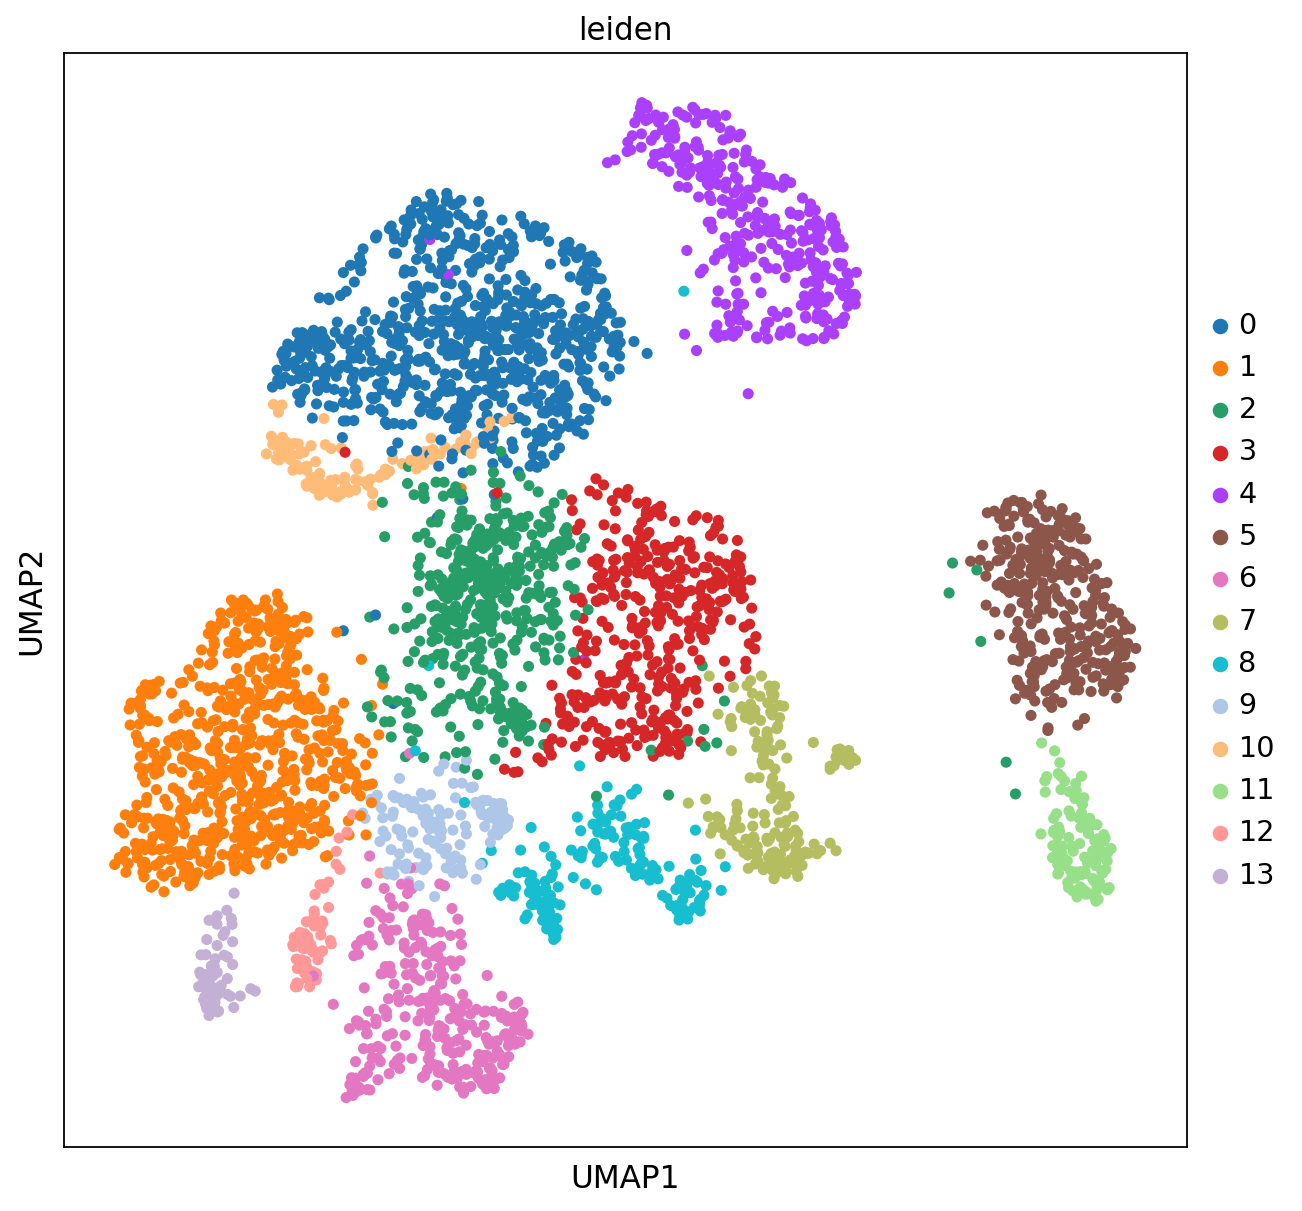

In [13]:
sc.set_figure_params(facecolor = 'white', figsize = (9,9))
sc.tl.pca(maize_Data, svd_solver='arpack', random_state= 200)
sc.pp.neighbors(maize_Data, n_neighbors=30, n_pcs=50, random_state= 500)
sc.tl.umap(maize_Data, random_state= 221)
sc.tl.leiden(maize_Data, random_state= 1000, resolution= .6)

sc.pl.umap(maize_Data, color = 'leiden', s=100)

In [14]:
maize_Data.obs['Cell Cluster Annotation'] = 'Not Annotated'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'] == '5'] = 'Epidermis'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['0','2','3','10'])] = 'Cortex'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['1'])] = 'Stele'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['4'])] = 'Exodermis'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['6'])] = 'CC'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['7'])] = 'Meristem'

maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['9'])] = 'Pericycle'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['11'])] = 'Root Hair'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['12'])] = 'Endodermis'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['13'])] = 'Protophloem'




/tmp/ipykernel_887241/1510908982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'] == '5'] = 'Epidermis'
/tmp/ipykernel_887241/1510908982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['0','2','3','10'])] = 'Cortex'
/tmp/ipykernel_887241/1510908982.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [15]:
rice_sc_data.var_names_make_unique()

In [16]:
sc.pp.normalize_total(rice_sc_data, target_sum=1e4)

sc.pp.log1p(rice_sc_data)

In [17]:
sc.pp.highly_variable_genes(rice_sc_data, min_mean=0.0125, max_mean=3, min_disp=.2)
#dispersion .5

In [18]:
sc.set_figure_params(facecolor = 'white', figsize = (9,9)) # Make figures bigger and on a white background because your PI is 70 and doesn't know what a .png is


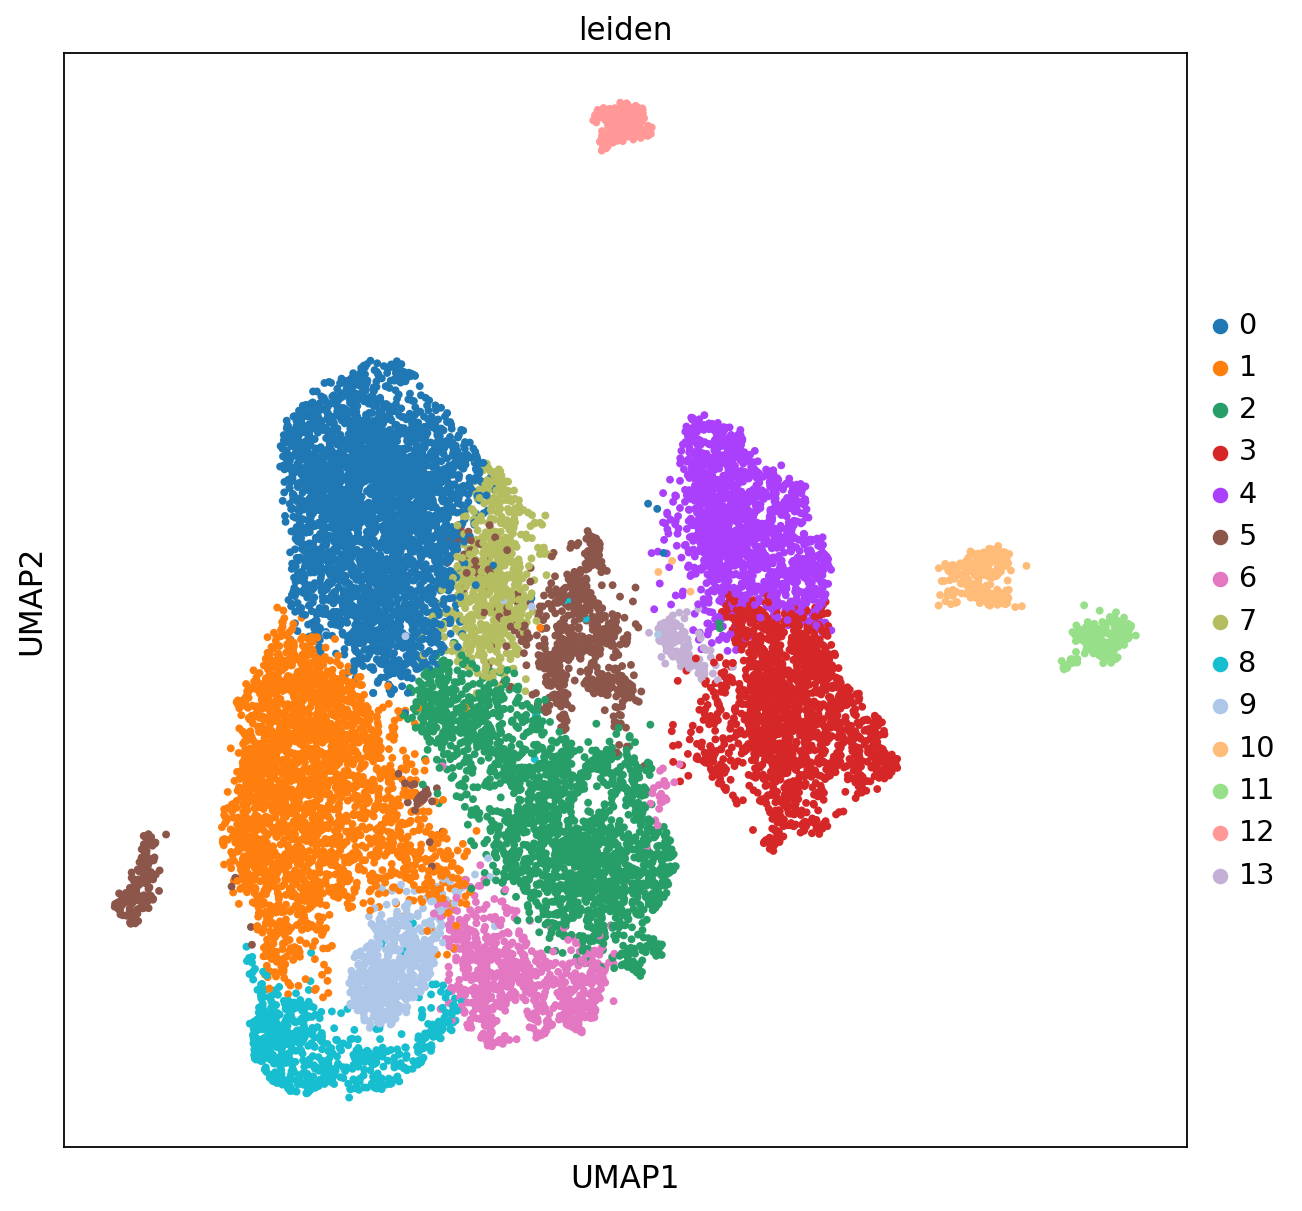

In [19]:
sc.tl.pca(rice_sc_data, svd_solver='arpack', random_state= 3456)
sc.pp.neighbors(rice_sc_data, n_neighbors=30, n_pcs=50, random_state= 112) ##30,50 # 25,45
sc.tl.umap(rice_sc_data, random_state= 649)
sc.tl.leiden(rice_sc_data, random_state= 823, resolution= .5)

sc.pl.umap(rice_sc_data, color = 'leiden', s=50,)

In [20]:
rice_sc_data.var_names_make_unique()

In [21]:
rice_sc_data.obs['Cell Cluster Annotation'] = 'Not Annotated'
rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['1','11'])] = 'Stele'
rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['0','3',])] = 'Cortex'
rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['2','5','6'])] = 'Epidermis'
rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['9'])] = 'Root Hair'

types_to_include_in_mapping = ['Epidermis','Cortex','Stele', 'Root Hair']

/tmp/ipykernel_887241/2794517125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['1','11'])] = 'Stele'
/tmp/ipykernel_887241/2794517125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['0','3',])] = 'Cortex'
/tmp/ipykernel_887241/2794517125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [22]:
sec_rice = rice_sc_data[rice_sc_data.obs.loc[rice_sc_data.obs['Cell Cluster Annotation'].isin(types_to_include_in_mapping)].index,:]
sec_rice

View of AnnData object with n_obs × n_vars = 11769 × 37863
    obs: 'leiden', 'Cell Cluster Annotation'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


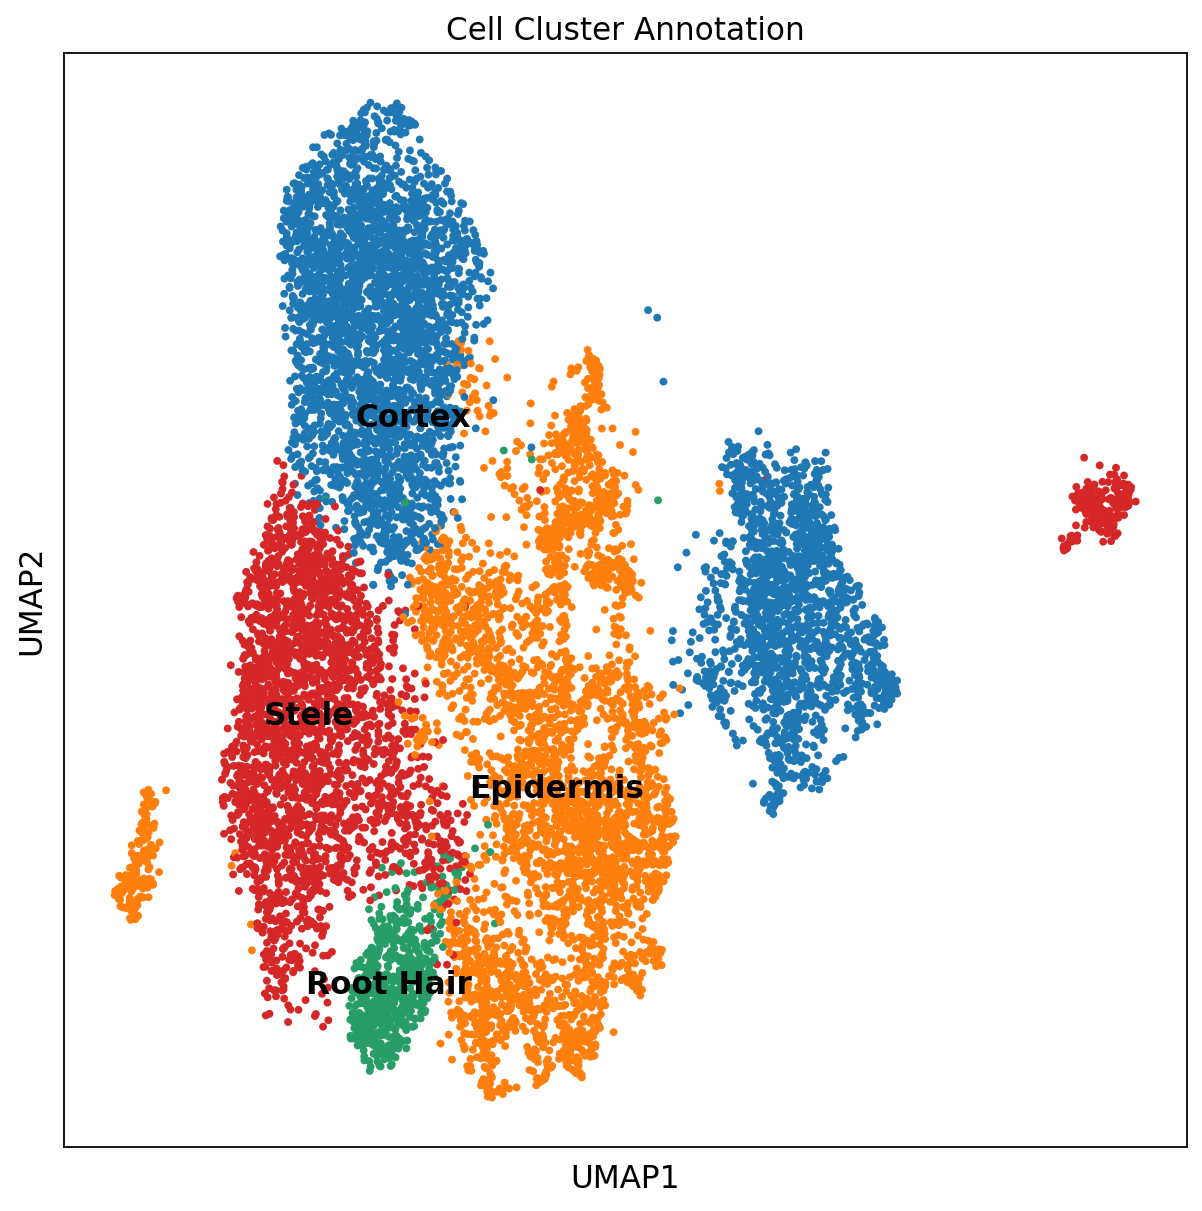

In [23]:
sc.pl.umap(sec_rice, color = ['Cell Cluster Annotation'], s=50, legend_loc = 'on data')

In [24]:
sec_maize = maize_Data[maize_Data.obs.loc[maize_Data.obs['Cell Cluster Annotation'].isin(types_to_include_in_mapping)].index,:]


/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


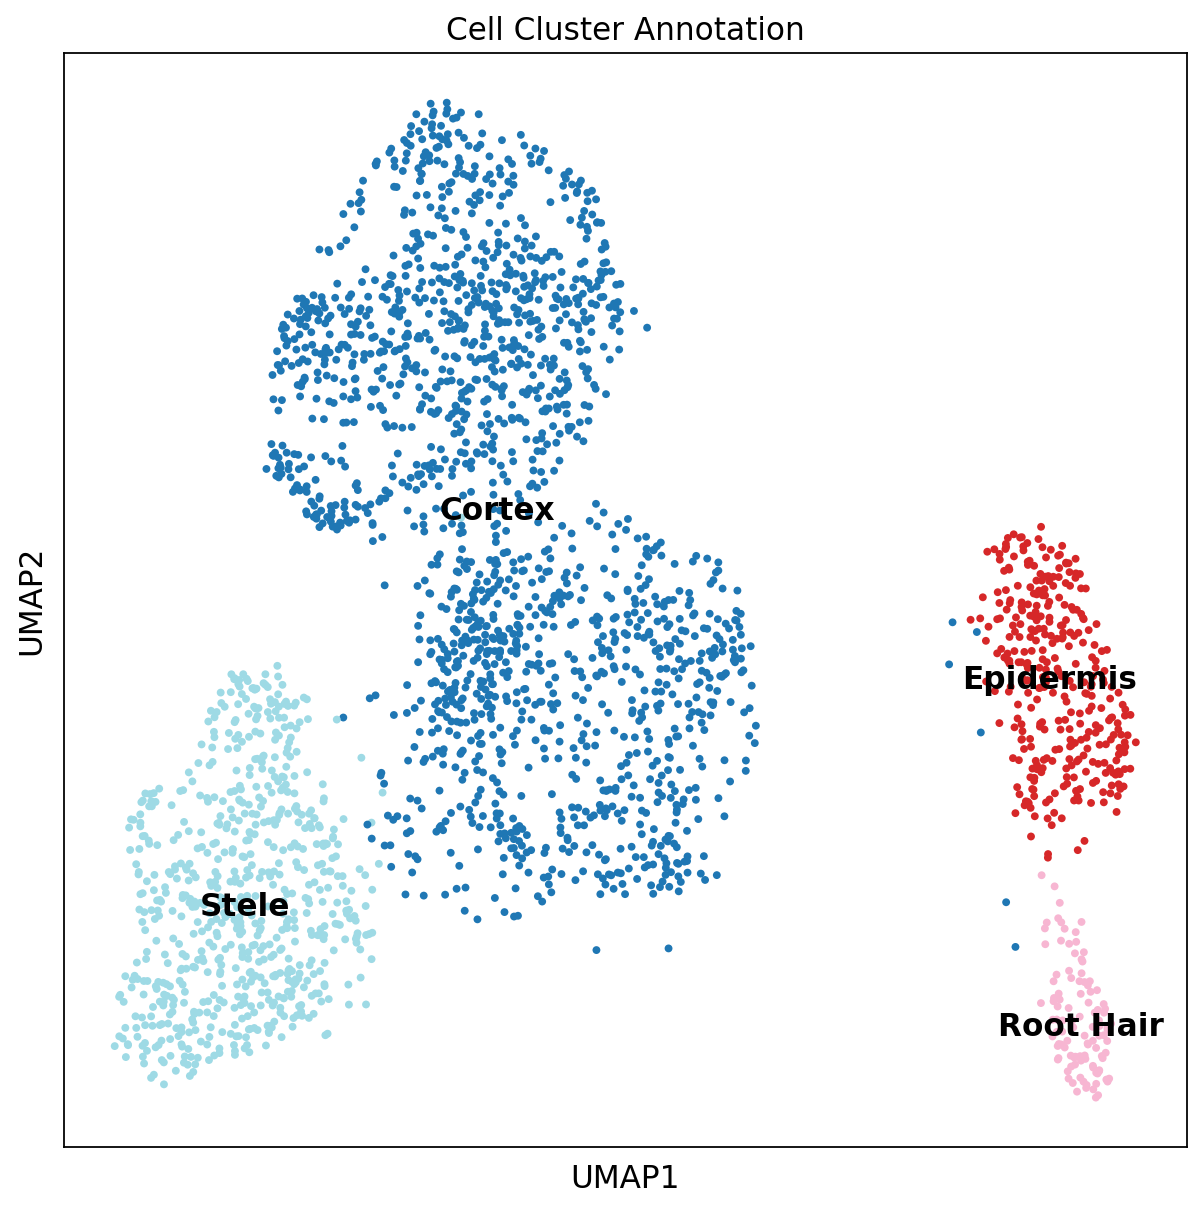

In [25]:
sc.pl.umap(sec_maize, color = ['Cell Cluster Annotation'],palette= 'tab20', s=50, legend_loc = 'on data')

In [26]:
sec_rice.var['Gene Name'] = sec_rice.var.index
sec_rice.var = sec_rice.var.rename(columns = {'Gene Name':'Gene ID'})
sec_rice.var = sec_rice.var.merge(right = co_expressalog_map_85, right_on = 'Rice Gene', how = 'left', left_on= 'Gene ID')
sec_rice.var

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


gene_ids    feature_types  highly_variable         means  \
0      Os01g0100100  Gene Expression            False  9.381453e-03   
1      Os01g0100200  Gene Expression            False  4.067292e-02   
2      Os01g0100300  Gene Expression            False  4.735694e-04   
3      Os01g0100400  Gene Expression            False  4.003630e-03   
4      Os01g0100466  Gene Expression            False  1.000000e-12   
...             ...              ...              ...           ...   
37858  Os12g0641200  Gene Expression            False  1.339002e-02   
37859  Os12g0641300  Gene Expression            False  1.637106e-02   
37860  Os12g0641400  Gene Expression             True  4.142963e-01   
37861  Os12g0641500  Gene Expression             True  6.777357e-02   
37862  Os12g0641600  Gene Expression            False  1.000000e-12   

       dispersions  dispersions_norm       Gene ID     Rice Gene  \
0         1.401757          0.553760  Os01g0100100           NaN   
1         0.994555         -0.085596  Os01g0100200           NaN   
2         0.386184         -1.040810  Os01g0100300           NaN   
3         0.607636         -0.693104  Os01g0100400           NaN   
4              NaN          0.000000  Os01g0100466           NaN   
...            ...               ...           ...           ...   
37858     0.937923         -0.174516  Os12g0641200           NaN   
37859     0.751851         -0.466670  Os12g0641300  Os12g0641300   
37860     1.574961          0.228052  Os12g0641400           NaN   
37861     1.372489          0.507805  Os12g0641500           NaN   
37862          NaN          0.000000  Os12g0641600           NaN   

           Maize Gene  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
...               ...  
37858             NaN  
37859  Zm00001d041191  
37860             NaN  
37861             NaN  
37862             NaN  

[37863 rows x 9 columns]

In [27]:
sec_rice.var = sec_rice.var.set_index('Gene ID')
sec_rice.var

gene_ids    feature_types  highly_variable         means  \
Gene ID                                                                      
Os01g0100100  Os01g0100100  Gene Expression            False  9.381453e-03   
Os01g0100200  Os01g0100200  Gene Expression            False  4.067292e-02   
Os01g0100300  Os01g0100300  Gene Expression            False  4.735694e-04   
Os01g0100400  Os01g0100400  Gene Expression            False  4.003630e-03   
Os01g0100466  Os01g0100466  Gene Expression            False  1.000000e-12   
...                    ...              ...              ...           ...   
Os12g0641200  Os12g0641200  Gene Expression            False  1.339002e-02   
Os12g0641300  Os12g0641300  Gene Expression            False  1.637106e-02   
Os12g0641400  Os12g0641400  Gene Expression             True  4.142963e-01   
Os12g0641500  Os12g0641500  Gene Expression             True  6.777357e-02   
Os12g0641600  Os12g0641600  Gene Expression            False  1.000000e-12   

              dispersions  dispersions_norm     Rice Gene      Maize Gene  
Gene ID                                                                    
Os01g0100100     1.401757          0.553760           NaN             NaN  
Os01g0100200     0.994555         -0.085596           NaN             NaN  
Os01g0100300     0.386184         -1.040810           NaN             NaN  
Os01g0100400     0.607636         -0.693104           NaN             NaN  
Os01g0100466          NaN          0.000000           NaN             NaN  
...                   ...               ...           ...             ...  
Os12g0641200     0.937923         -0.174516           NaN             NaN  
Os12g0641300     0.751851         -0.466670  Os12g0641300  Zm00001d041191  
Os12g0641400     1.574961          0.228052           NaN             NaN  
Os12g0641500     1.372489          0.507805           NaN             NaN  
Os12g0641600          NaN          0.000000           NaN             NaN  

[37863 rows x 8 columns]

In [28]:
sec_maize.var = sec_maize.var.merge(right = co_expressalog_map_85, how = 'left', right_on= 'Maize Gene', left_on='gene_ids')
sec_maize.var

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


gene_ids    feature_types  n_cells  highly_variable     means  \
0       Zm00001d027230  Gene Expression       67            False  0.024387   
1       Zm00001d027231  Gene Expression      290             True  0.241811   
2       Zm00001d027233  Gene Expression        2            False  0.000593   
3       Zm00001d027236  Gene Expression       36             True  0.021745   
4       Zm00001d027239  Gene Expression       60            False  0.023626   
...                ...              ...      ...              ...       ...   
25648  ENSRNA049478534  Gene Expression       67             True  0.090445   
25649  ENSRNA049478548  Gene Expression        8            False  0.010975   
25650  ENSRNA049478530  Gene Expression      217             True  0.307557   
25651   Zm00001d000458  Gene Expression        2            False  0.000167   
25652   Zm00001d000460  Gene Expression        4            False  0.001130   

       dispersions  dispersions_norm Rice Gene Maize Gene  
0         1.696221         -0.095275       NaN        NaN  
1         2.104409          0.435565       NaN        NaN  
2         0.203313         -2.036773       NaN        NaN  
3         2.032777          0.342410       NaN        NaN  
4         1.419417         -0.455253       NaN        NaN  
...            ...               ...       ...        ...  
25648     2.502171          0.952848       NaN        NaN  
25649     2.160190          0.508108       NaN        NaN  
25650     2.541439          1.507421       NaN        NaN  
25651    -0.994376         -3.594344       NaN        NaN  
25652     0.942761         -1.075135       NaN        NaN  

[25653 rows x 9 columns]

In [29]:
rice_var_names_with_ortholog = sec_rice.var.dropna().index
rice_version_of_maize_genes_with_ortholog = sec_maize.var.dropna()['Rice Gene'].to_list()

rice_var_names_with_ortholog
overlap_of_shared_genes = rice_var_names_with_ortholog.intersection(rice_version_of_maize_genes_with_ortholog)

maize_genes_to_keep = sec_maize.var.loc[sec_maize.var['Rice Gene'].isin(overlap_of_shared_genes)].index

In [30]:
sec_maize.var = sec_maize.var.set_index('gene_ids')


In [31]:
sec_maize

AnnData object with n_obs × n_vars = 2832 × 25653
    obs: 'n_genes', 'leiden', 'Cell Cluster Annotation'
    var: 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Rice Gene', 'Maize Gene'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell Cluster Annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [32]:
maize_single_cell_trimmed_to_orthologs = sec_maize[:,maize_genes_to_keep]
maize_single_cell_trimmed_to_orthologs

View of AnnData object with n_obs × n_vars = 2832 × 7189
    obs: 'n_genes', 'leiden', 'Cell Cluster Annotation'
    var: 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Rice Gene', 'Maize Gene'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell Cluster Annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [33]:
rice_genes_to_keep = sec_rice.var.loc[sec_rice.var['Rice Gene'].isin(overlap_of_shared_genes)].index

In [34]:
rice_genes_to_keep

Index(['Os01g0100600', 'Os01g0101600', 'Os01g0101800', 'Os01g0102600',
       'Os01g0102800', 'Os01g0102900', 'Os01g0103100', 'Os01g0103600',
       'Os01g0103800', 'Os01g0104000',
       ...
       'Os12g0635500', 'Os12g0635700', 'Os12g0638400', 'Os12g0638600',
       'Os12g0638800', 'Os12g0638900', 'Os12g0639400', 'Os12g0640600',
       'Os12g0640800', 'Os12g0641100'],
      dtype='object', name='Gene ID', length=7189)

In [35]:
rice_single_cell_slimmed_to_orthologs = sec_rice[:,rice_genes_to_keep]
rice_single_cell_slimmed_to_orthologs

View of AnnData object with n_obs × n_vars = 11769 × 7189
    obs: 'leiden', 'Cell Cluster Annotation'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Rice Gene', 'Maize Gene'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell Cluster Annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [36]:
maize_single_cell_trimmed_to_orthologs.var.index = maize_single_cell_trimmed_to_orthologs.var['Rice Gene'].to_list()
maize_single_cell_trimmed_to_orthologs.var

feature_types  n_cells  highly_variable     means  \
Os10g0563000  Gene Expression      379             True  0.369343   
Os10g0561300  Gene Expression       34            False  0.009267   
Os10g0561100  Gene Expression      149             True  0.119988   
Os03g0102700  Gene Expression       27             True  0.065732   
Os03g0103400  Gene Expression       23            False  0.008448   
...                       ...      ...              ...       ...   
Os05g0337200  Gene Expression       10            False  0.011050   
Os08g0110300  Gene Expression      672            False  0.516153   
Os06g0650600  Gene Expression      177             True  0.149739   
Os06g0650800  Gene Expression      166            False  0.076455   
Os12g0407900  Gene Expression       77             True  0.049296   

              dispersions  dispersions_norm     Rice Gene      Maize Gene  
Os10g0563000     2.289217          0.462854  Os10g0563000  Zm00001d027267  
Os10g0561300     1.474556         -0.383545  Os10g0561300  Zm00001d027268  
Os10g0561100     2.328042          0.726396  Os10g0561100  Zm00001d027276  
Os03g0102700     2.914063          1.488505  Os03g0102700  Zm00001d027283  
Os03g0103400     1.098461         -0.872650  Os03g0103400  Zm00001d027292  
...                   ...               ...           ...             ...  
Os05g0337200     2.403927          0.825084  Os05g0337200  Zm00001d000400  
Os08g0110300     2.194668         -0.250254  Os08g0110300  Zm00001d000424  
Os06g0650600     2.224363          0.591564  Os06g0650600  Zm00001d000428  
Os06g0650800     1.847174          0.101037  Os06g0650800  Zm00001d000430  
Os12g0407900     2.094920          0.423226  Os12g0407900  Zm00001d000435  

[7189 rows x 8 columns]

In [37]:
order_of_vars = rice_single_cell_slimmed_to_orthologs.var.index.to_list()
current_order_maize_vars = maize_single_cell_trimmed_to_orthologs.var_names
panda_version_of_maize_x_data = pd.DataFrame(columns = current_order_maize_vars, data = maize_single_cell_trimmed_to_orthologs.X.todense())
re_ordered_version = panda_version_of_maize_x_data.reindex(columns = order_of_vars)
re_ordered_version = sparse.csr_matrix(re_ordered_version.values)
maize_single_cell_trimmed_to_orthologs.X = re_ordered_version
maize_single_cell_trimmed_to_orthologs.var = maize_single_cell_trimmed_to_orthologs.var.reindex(order_of_vars)

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [38]:
import pymn
import scgen

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [39]:
concatendated_rice_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(rice_single_cell_slimmed_to_orthologs, batch_key = 'Species', batch_categories = ['Maize','Rice'])
concatendated_rice_maize_dataset.var = concatendated_rice_maize_dataset.var.merge(on = ['Maize Gene','Rice Gene'], right = one_to_ones, how = 'left')
concatendated_rice_maize_dataset.var.set_index('Rice Gene', drop= False, inplace = True)
concatendated_rice_maize_dataset.var.replace(np.nan,'No', inplace= True)


/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [40]:
dropper_table = concatendated_rice_maize_dataset.var[['Rice Gene','Maize Gene','One to One']]
dropper_table['Drop Status'] = 'Do Not Drop' 
dropper_table


/tmp/ipykernel_887241/1103001383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropper_table['Drop Status'] = 'Do Not Drop'


Rice Gene      Maize Gene One to One  Drop Status
Rice Gene                                                         
Os01g0100600  Os01g0100600  Zm00001d029189         No  Do Not Drop
Os01g0101600  Os01g0101600  Zm00001d008390         No  Do Not Drop
Os01g0101800  Os01g0101800  Zm00001d040213         No  Do Not Drop
Os01g0102600  Os01g0102600  Zm00001d030688        Yes  Do Not Drop
Os01g0102800  Os01g0102800  Zm00001d040203        Yes  Do Not Drop
...                    ...             ...        ...          ...
Os12g0638900  Os12g0638900  Zm00001d031217        Yes  Do Not Drop
Os12g0639400  Os12g0639400  Zm00001d031222        Yes  Do Not Drop
Os12g0640600  Os12g0640600  Zm00001d048373        Yes  Do Not Drop
Os12g0640800  Os12g0640800  Zm00001d031231         No  Do Not Drop
Os12g0641100  Os12g0641100  Zm00001d031232        Yes  Do Not Drop

[7189 rows x 4 columns]

In [41]:
dropper_table.loc[dropper_table['One to One'] == 'Yes']

Rice Gene      Maize Gene One to One  Drop Status
Rice Gene                                                         
Os01g0102600  Os01g0102600  Zm00001d030688        Yes  Do Not Drop
Os01g0102800  Os01g0102800  Zm00001d040203        Yes  Do Not Drop
Os01g0102900  Os01g0102900  Zm00001d040202        Yes  Do Not Drop
Os01g0103100  Os01g0103100  Zm00001d040201        Yes  Do Not Drop
Os01g0104000  Os01g0104000  Zm00001d040192        Yes  Do Not Drop
...                    ...             ...        ...          ...
Os12g0638800  Os12g0638800  Zm00001d031216        Yes  Do Not Drop
Os12g0638900  Os12g0638900  Zm00001d031217        Yes  Do Not Drop
Os12g0639400  Os12g0639400  Zm00001d031222        Yes  Do Not Drop
Os12g0640600  Os12g0640600  Zm00001d048373        Yes  Do Not Drop
Os12g0641100  Os12g0641100  Zm00001d031232        Yes  Do Not Drop

[4078 rows x 4 columns]

In [42]:
8*509

4072

In [43]:
def cell_type_score_calculator(adata):
    species = ['Rice','Maize']
    list_of_celltype_scores = []
    for celltype in ['Epidermis', 'Cortex', 'Stele', 'Root Hair']:
        target_1 = 'Rice'+'|'+celltype 
        target_2 = 'Maize'+'|'+celltype 
        peripheral_1 = adata.uns['MetaNeighborUS'].at[target_1,target_2]
        peripheral_2 = adata.uns['MetaNeighborUS'].at[target_2,target_1]
        avg_score = (peripheral_1+peripheral_2)/2
        list_of_celltype_scores.append(avg_score)
    return list_of_celltype_scores

In [44]:
# list_of_cell_type_score_lists = []
# for drop_step in np.arange(255):
#     print(drop_step)
    
#     concatendated_rice_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(rice_single_cell_slimmed_to_orthologs, batch_key = 'Species', batch_categories = ['Maize','Rice'])
#     kept_this_round = dropper_table.loc[dropper_table['Drop Status'] == 'Do Not Drop'].index
#     concatendated_rice_maize_dataset = concatendated_rice_maize_dataset[:,kept_this_round]

#     concatendated_rice_maize_dataset = concatendated_rice_maize_dataset.copy()

#     scgen.SCGEN.setup_anndata(concatendated_rice_maize_dataset, batch_key="Species", labels_key="Cell Cluster Annotation")
#     model = scgen.SCGEN(concatendated_rice_maize_dataset)
#     model.train(
#         max_epochs=100,
#         batch_size=32,
#         early_stopping=True,
#         early_stopping_patience=25,
#     )
#     corrected_adata = model.batch_removal()
#     pymn.variableGenes(corrected_adata,study_col = 'Species')
#     pymn.MetaNeighborUS(corrected_adata,study_col = 'Species',ct_col = 'Cell Cluster Annotation')
#     this_level_results = cell_type_score_calculator(corrected_adata)
#     list_of_cell_type_score_lists.append(this_level_results)

#     drop_this_round = dropper_table['Drop Status'].loc[(dropper_table['One to One'] == 'Yes')&(dropper_table['Drop Status'] == 'Do Not Drop')].sample(n = 8).index
#     dropper_table['Drop Status'].loc[drop_this_round] = 'Drop'

In [45]:
import pickle
#pickle.dump(list_of_cell_type_score_lists, open('/data/passala/Generated_Tables/Maize_Rice_integration/ultra_detail_loss_curve_data.p','wb'))
#pickle.dump(dropper_table, open('/data/passala/Generated_Tables/Maize_Rice_integration/dropper_table_checkpoint.p','wb'))
dropper_table = pickle.load(open('/data/passala/Generated_Tables/Maize_Rice_integration/dropper_table_checkpoint.p', "rb"))
list_of_cell_type_score_lists = pickle.load(open('/data/passala/Generated_Tables/Maize_Rice_integration/ultra_detail_loss_curve_data.p', "rb"))

In [46]:
dropper_table

Rice Gene      Maize Gene One to One  Drop Status
Rice Gene                                                         
Os01g0100600  Os01g0100600  Zm00001d029189         No  Do Not Drop
Os01g0101600  Os01g0101600  Zm00001d008390         No  Do Not Drop
Os01g0101800  Os01g0101800  Zm00001d040213         No  Do Not Drop
Os01g0102600  Os01g0102600  Zm00001d030688        Yes         Drop
Os01g0102800  Os01g0102800  Zm00001d040203        Yes         Drop
...                    ...             ...        ...          ...
Os12g0638900  Os12g0638900  Zm00001d031217        Yes         Drop
Os12g0639400  Os12g0639400  Zm00001d031222        Yes         Drop
Os12g0640600  Os12g0640600  Zm00001d048373        Yes         Drop
Os12g0640800  Os12g0640800  Zm00001d031231         No  Do Not Drop
Os12g0641100  Os12g0641100  Zm00001d031232        Yes         Drop

[7189 rows x 4 columns]

In [47]:
list_of_cell_type_score_lists

[[0.9564203251253214,
  0.9845195943399088,
  0.969843196230143,
  0.9999653784019311],
 [0.8563622595933815,
  0.9571037151943551,
  0.9803652449143416,
  0.9955765989683595],
 [0.9485256763976926,
  0.9877110970797068,
  0.9194780078639846,
  0.9983685642965265],
 [0.9541845709200881,
  0.9779374282996259,
  0.8223013186363048,
  0.999848324230153],
 [0.8511570073016612,
  0.9230089154187087,
  0.9814873399444514,
  0.9990150149215087],
 [0.9087929442077478,
  0.9744100844651493,
  0.816439267549114,
  0.9971170329964569],
 [0.9468119444111673,
  0.9852395916504426,
  0.9445443293560449,
  0.9999329115479911],
 [0.9564241047560117,
  0.9842490752094883,
  0.9720990913134744,
  0.9999042299842358],
 [0.9576856858784548,
  0.9847246854698095,
  0.9510096340325915,
  0.9993709883227404],
 [0.9489186246137454,
  0.9883336537908491,
  0.957479423133005,
  0.999975970808193],
 [0.930380907917089,
  0.9873975068788223,
  0.9509369366925247,
  0.9994648780767645],
 [0.9622098484402796,
  0.9

In [48]:
# for drop_step in np.arange(255):
#     print(drop_step)
    
#     concatendated_rice_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(rice_single_cell_slimmed_to_orthologs, batch_key = 'Species', batch_categories = ['Maize','Rice'])
#     kept_this_round = dropper_table.loc[dropper_table['Drop Status'] == 'Do Not Drop'].index
#     concatendated_rice_maize_dataset = concatendated_rice_maize_dataset[:,kept_this_round]

#     concatendated_rice_maize_dataset = concatendated_rice_maize_dataset.copy()

#     scgen.SCGEN.setup_anndata(concatendated_rice_maize_dataset, batch_key="Species", labels_key="Cell Cluster Annotation")
#     model = scgen.SCGEN(concatendated_rice_maize_dataset)
#     model.train(
#         max_epochs=100,
#         batch_size=32,
#         early_stopping=True,
#         early_stopping_patience=25,
#     )
#     corrected_adata = model.batch_removal()
#     pymn.variableGenes(corrected_adata,study_col = 'Species')
#     pymn.MetaNeighborUS(corrected_adata,study_col = 'Species',ct_col = 'Cell Cluster Annotation')
#     this_level_results = cell_type_score_calculator(corrected_adata)
#     list_of_cell_type_score_lists.append(this_level_results)

#     drop_this_round = dropper_table['Drop Status'].loc[(dropper_table['One to One'] == 'Yes')&(dropper_table['Drop Status'] == 'Do Not Drop')].sample(n = 8).index
#     dropper_table['Drop Status'].loc[drop_this_round] = 'Drop'

In [49]:
len(list_of_cell_type_score_lists)

510

In [50]:
import pickle
#pickle.dump(list_of_cell_type_score_lists, open('/data/passala/Generated_Tables/Maize_Rice_integration/ultra_detail_loss_curve_data.p','wb'))
#pickle.dump(dropper_table, open('/data/passala/Generated_Tables/Maize_Rice_integration/dropper_table_checkpoint.p','wb'))
#list_of_cell_type_score_lists = pickle.load(open('/data/passala/Generated_Tables/Maize_Rice_integration/ultra_detail_loss_curve_data.p', "rb"))

In [51]:
len(np.arange(100))

100

In [52]:
cell_type_score_table = pd.DataFrame(data = list_of_cell_type_score_lists, columns= ['Epidermis', 'Cortex', 'Stele', 'Root Hair'])
cell_type_score_table['Step'] = np.arange(510)

In [53]:
tidy_table = cell_type_score_table.melt(id_vars = 'Step')

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:ylabel='Root Hair'>

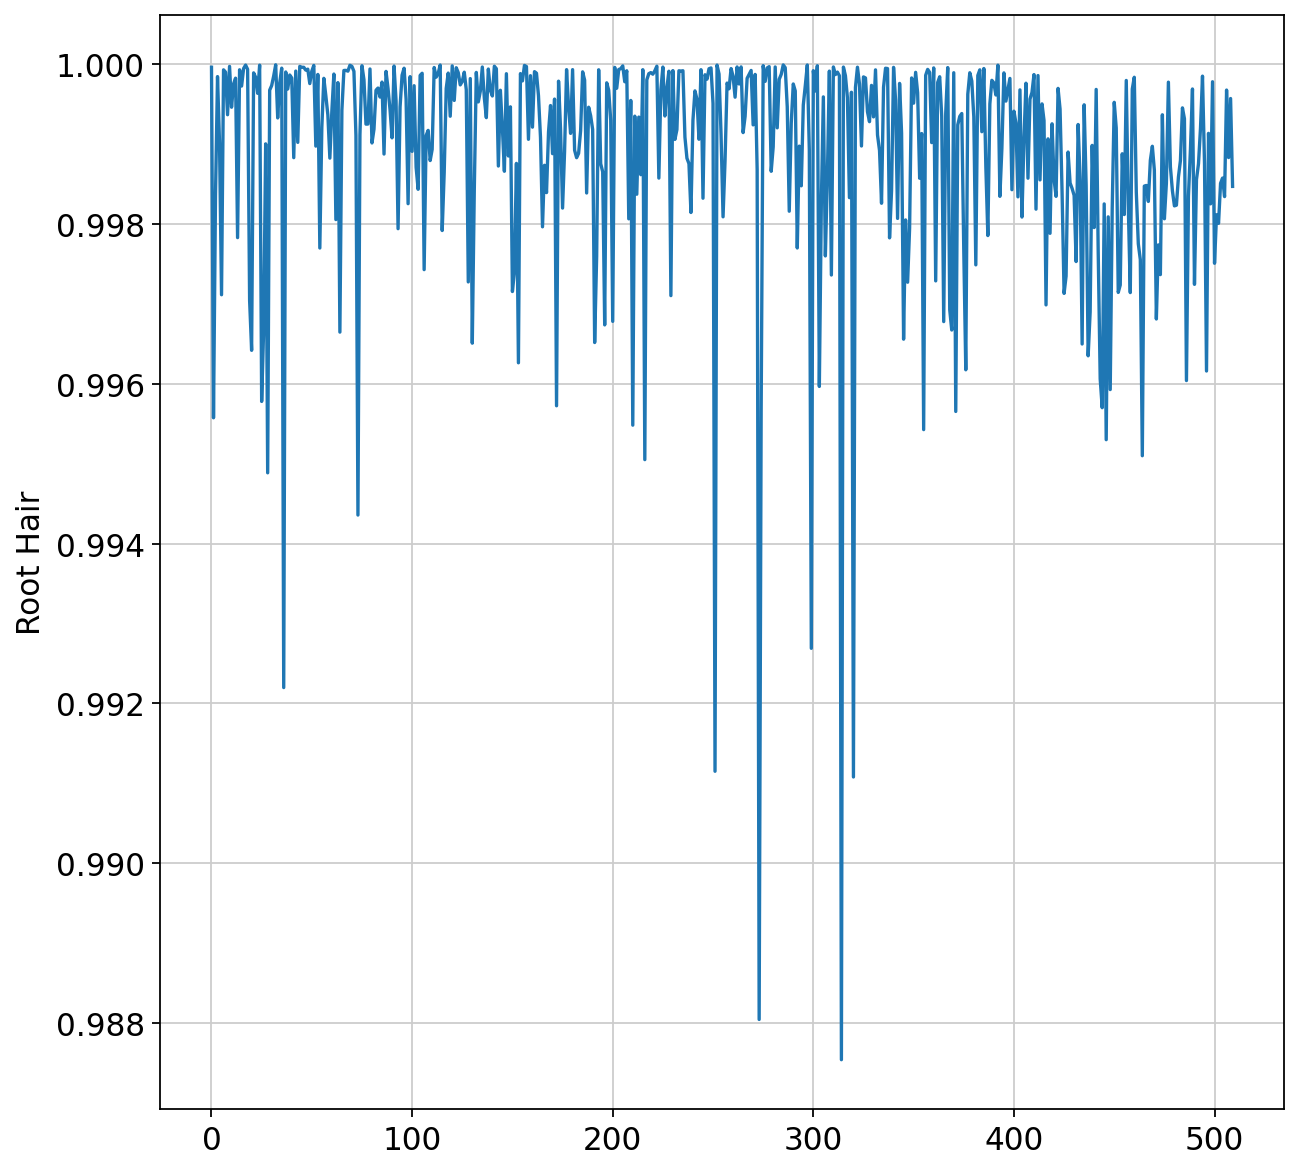

In [55]:
sns.lineplot(x = np.arange(510), y = cell_type_score_table['Root Hair'])

<AxesSubplot:ylabel='Epidermis'>

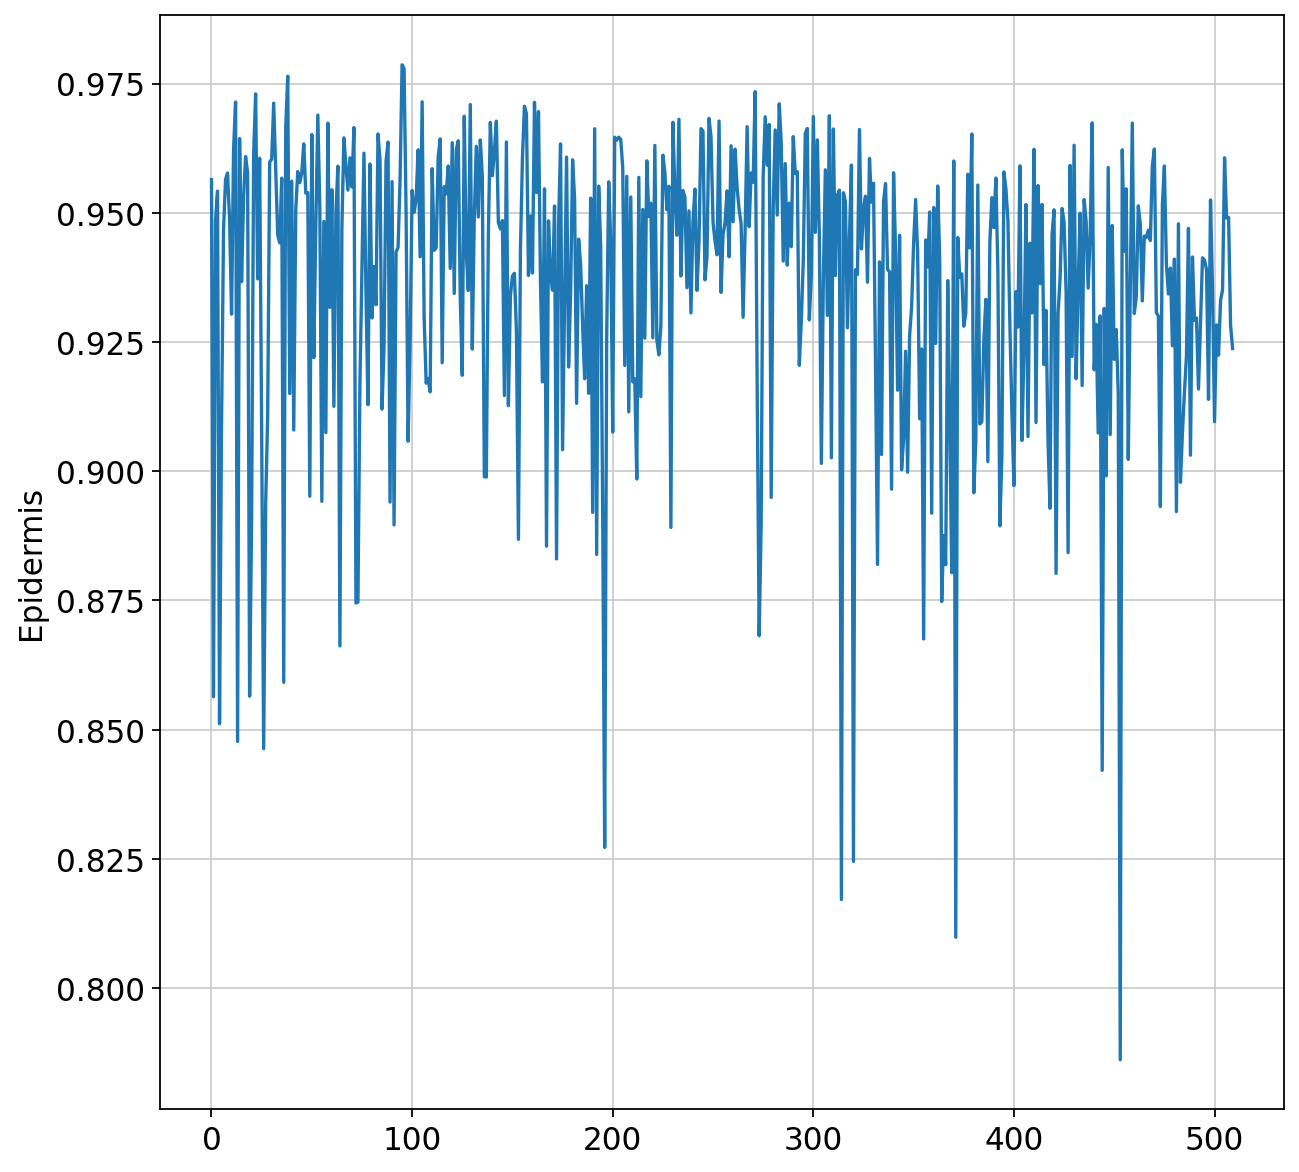

In [56]:
sns.lineplot(x = np.arange(510), y = cell_type_score_table['Epidermis'])

<AxesSubplot:ylabel='Cortex'>

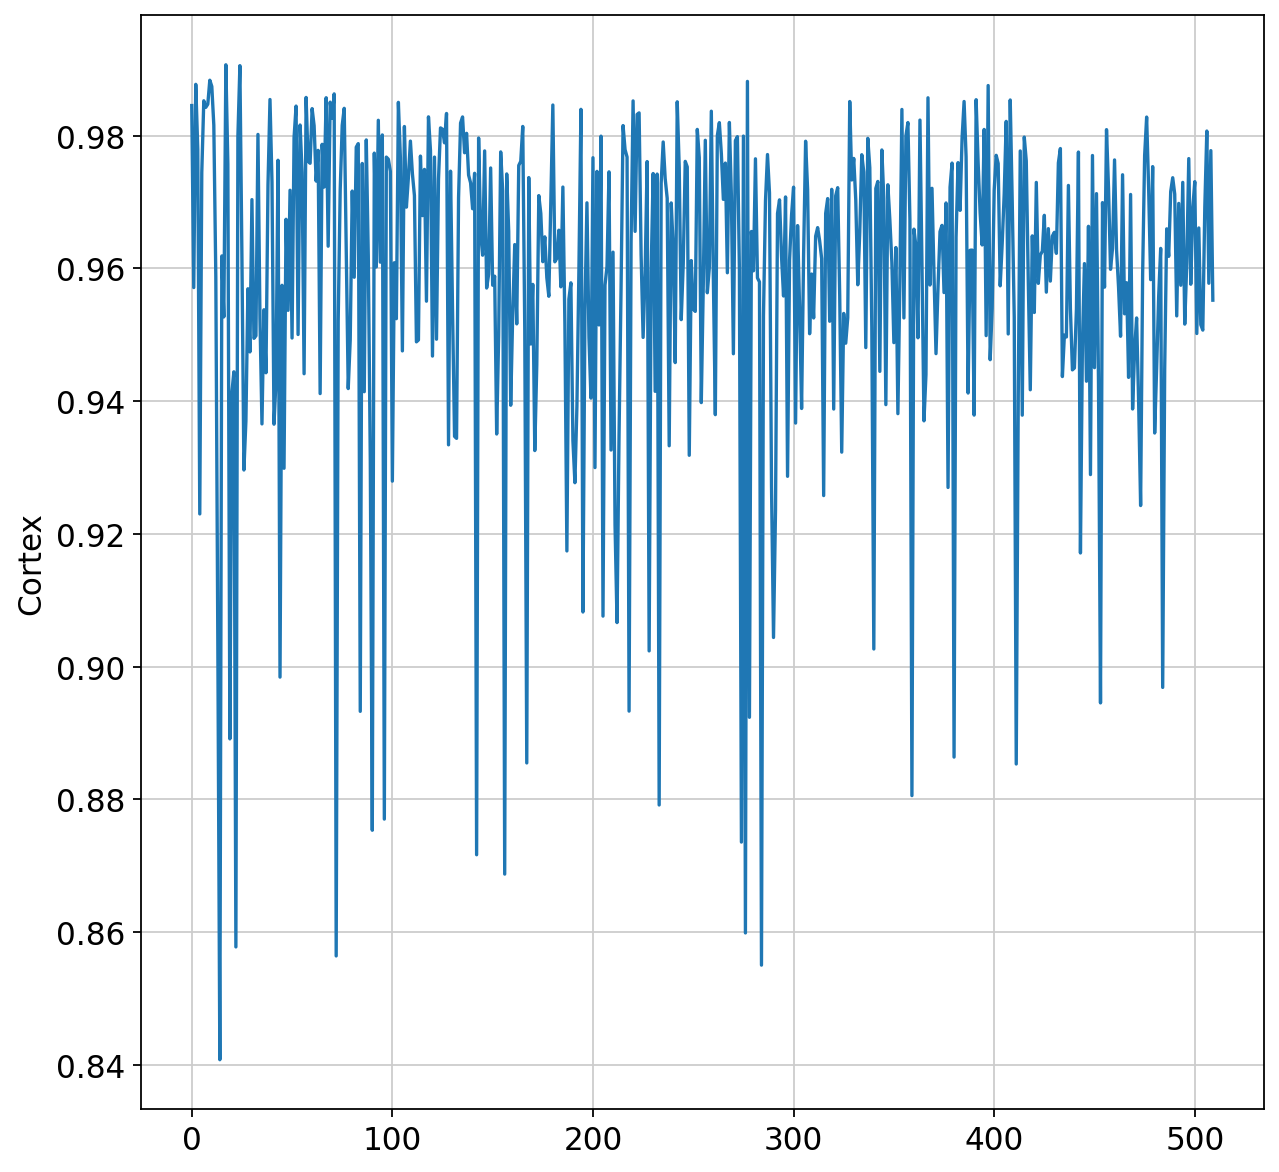

In [57]:
sns.lineplot(x = np.arange(510), y = cell_type_score_table['Cortex'])

<AxesSubplot:ylabel='Stele'>

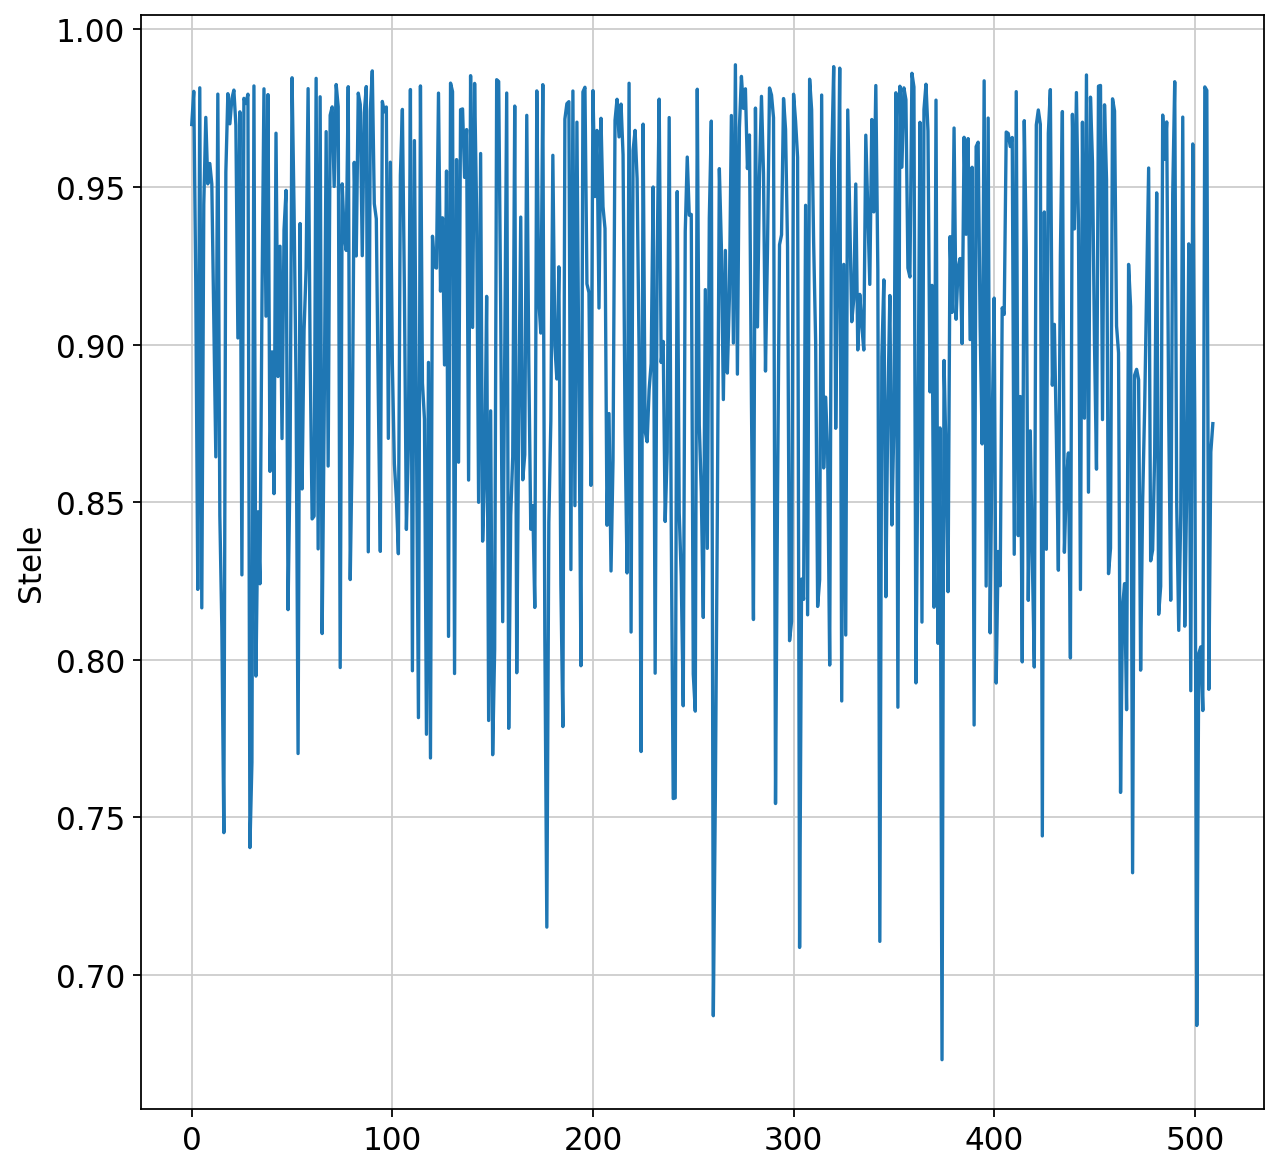

In [58]:
sns.lineplot(x = np.arange(510), y = cell_type_score_table['Stele'])

In [73]:
cell_type_score_table['Stele Rolling 10 Average'] = cell_type_score_table['Stele'].rolling(50).mean().shift(-25)


<AxesSubplot:ylabel='Stele Rolling 10 Average'>

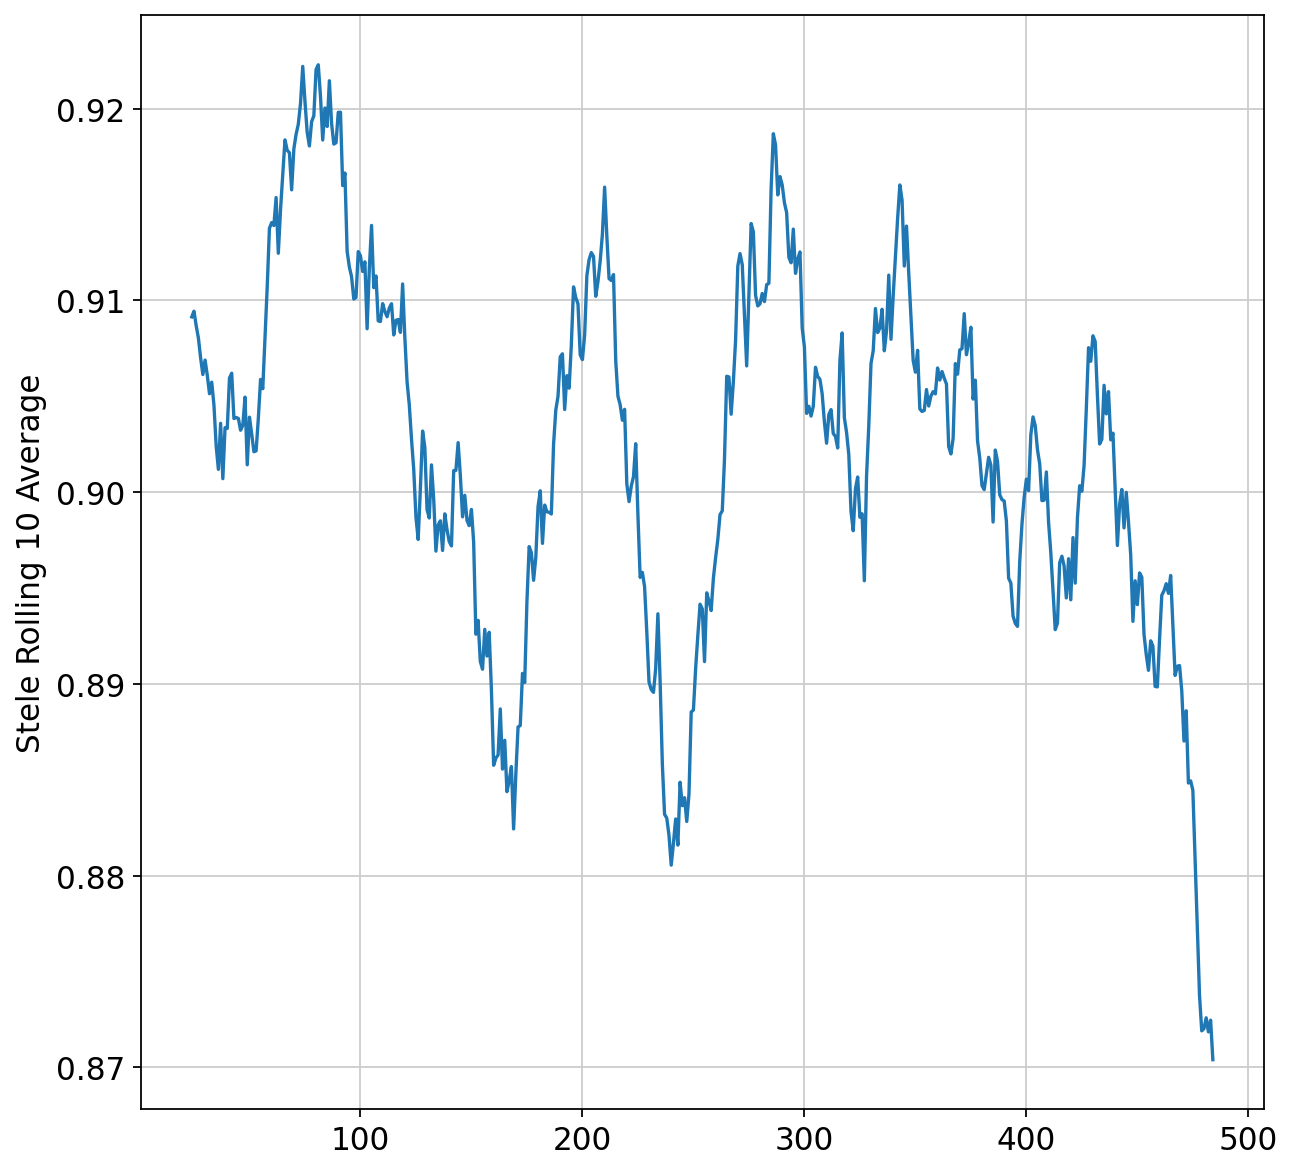

In [76]:
sns.lineplot(x = np.arange(510), y = cell_type_score_table['Stele Rolling 10 Average'])

In [77]:
uno_to_uno_cells_excluded = np.arange(510) *8 
uno_to_uno_cells_excluded

array([   0,    8,   16,   24,   32,   40,   48,   56,   64,   72,   80,
         88,   96,  104,  112,  120,  128,  136,  144,  152,  160,  168,
        176,  184,  192,  200,  208,  216,  224,  232,  240,  248,  256,
        264,  272,  280,  288,  296,  304,  312,  320,  328,  336,  344,
        352,  360,  368,  376,  384,  392,  400,  408,  416,  424,  432,
        440,  448,  456,  464,  472,  480,  488,  496,  504,  512,  520,
        528,  536,  544,  552,  560,  568,  576,  584,  592,  600,  608,
        616,  624,  632,  640,  648,  656,  664,  672,  680,  688,  696,
        704,  712,  720,  728,  736,  744,  752,  760,  768,  776,  784,
        792,  800,  808,  816,  824,  832,  840,  848,  856,  864,  872,
        880,  888,  896,  904,  912,  920,  928,  936,  944,  952,  960,
        968,  976,  984,  992, 1000, 1008, 1016, 1024, 1032, 1040, 1048,
       1056, 1064, 1072, 1080, 1088, 1096, 1104, 1112, 1120, 1128, 1136,
       1144, 1152, 1160, 1168, 1176, 1184, 1192, 12

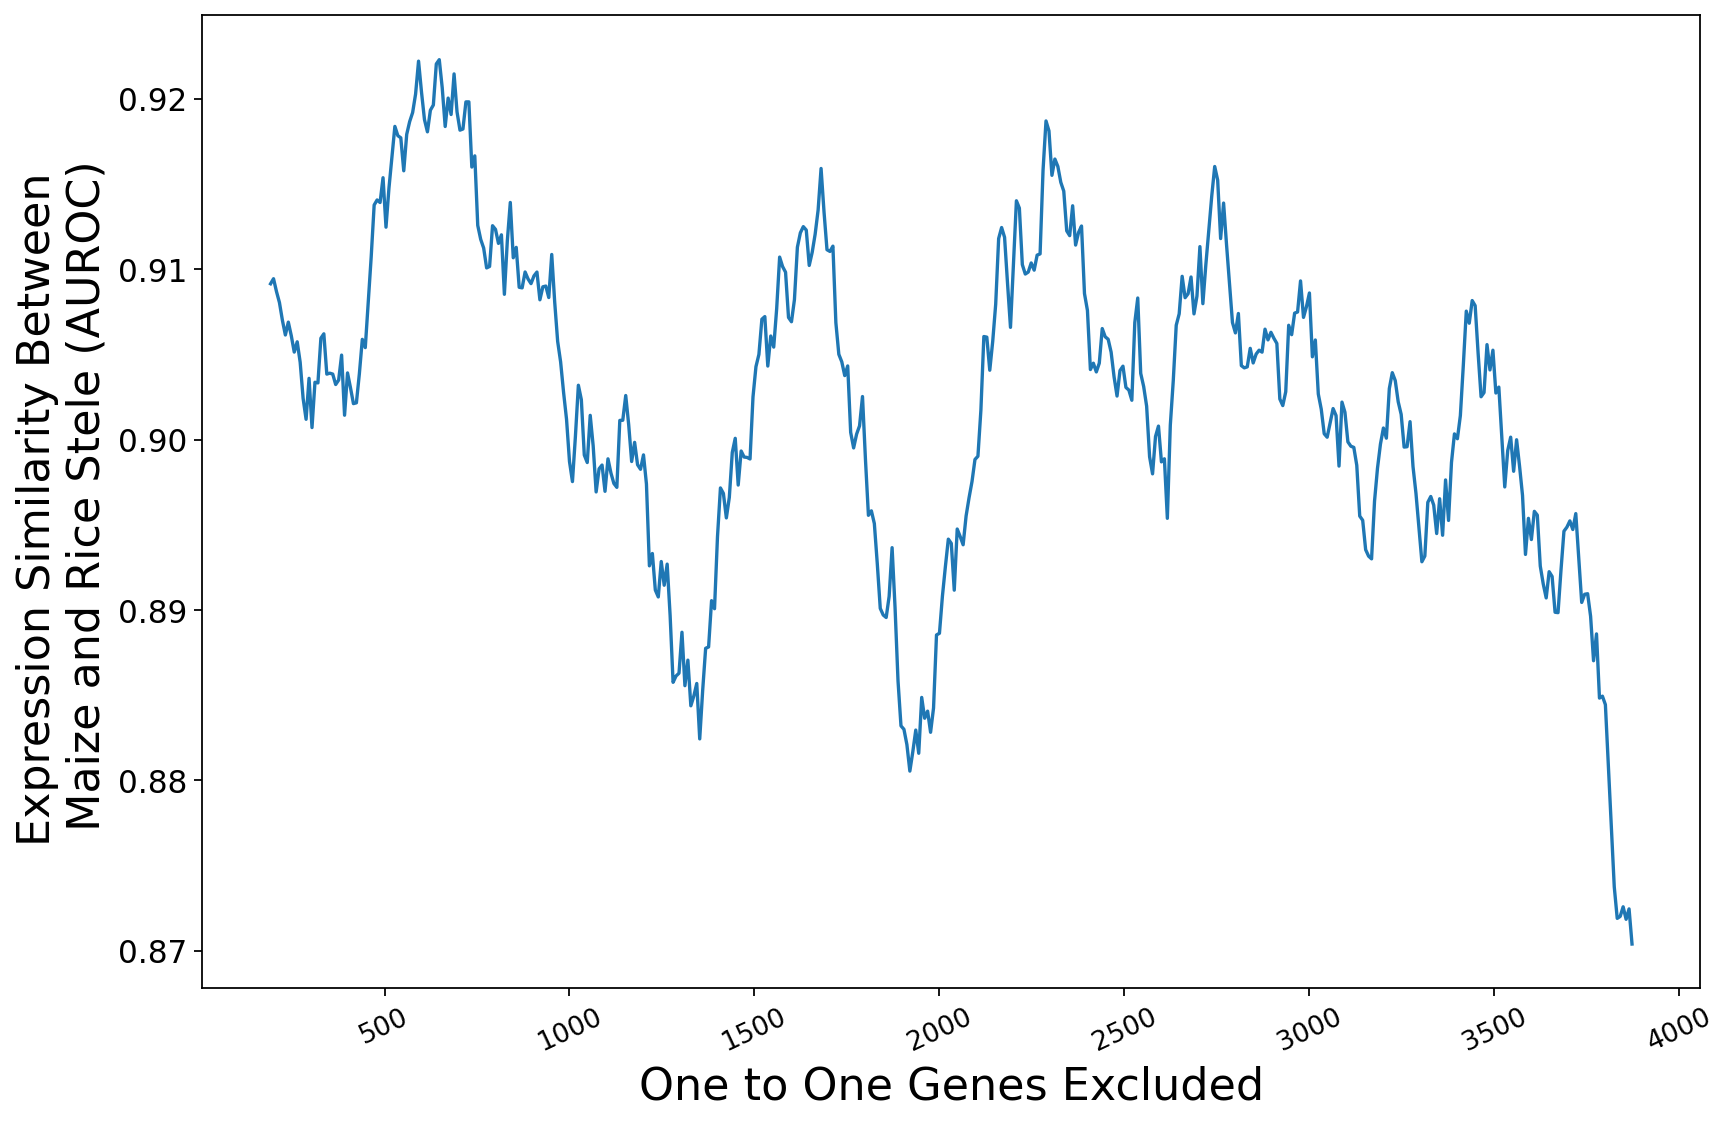

In [84]:
fig, ax = plt.subplots(figsize = (12,8))
fig.patch.set_facecolor('white')
ax = sns.lineplot(x = uno_to_uno_cells_excluded, y = cell_type_score_table['Stele Rolling 10 Average']) #style = 'Gene', dashes = True
plt.ylabel("Expression Similarity Between \n Maize and Rice Stele (AUROC)", fontsize = 20)
plt.xlabel("One to One Genes Excluded", fontsize = 20)
# sns.despine()

ax.grid(False)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
#ax.set_xticks([1,2,3,4], labels=['Epidermis','Stele','Cortex','Root Hair'])
#ax.set_xticklabels(['Phloem 1','Xylem','Endodermis 2','Phloem 2','Endodermis','Atrichoblasts/Columella','Trichoblasts','Meristematic/QC','Cortex'])
#plt.xlim((-7,7))
# plt.ylim((0, 1250))
#plt.title("Current Threshold is 31", fontsize = 20)
plt.xticks(fontsize = 12, rotation = 25)
#plt.yticks(fontsize = 11)
plt.savefig('/data/passala/Plots_for_projects/Coexpressolog_paper_plots/Stele_dropping_genes.svg')

In [85]:
cell_type_score_table['Epidermis Rolling 10 Average'] = cell_type_score_table['Epidermis'].rolling(50).mean().shift(-25)


<AxesSubplot:ylabel='Epidermis Rolling 10 Average'>

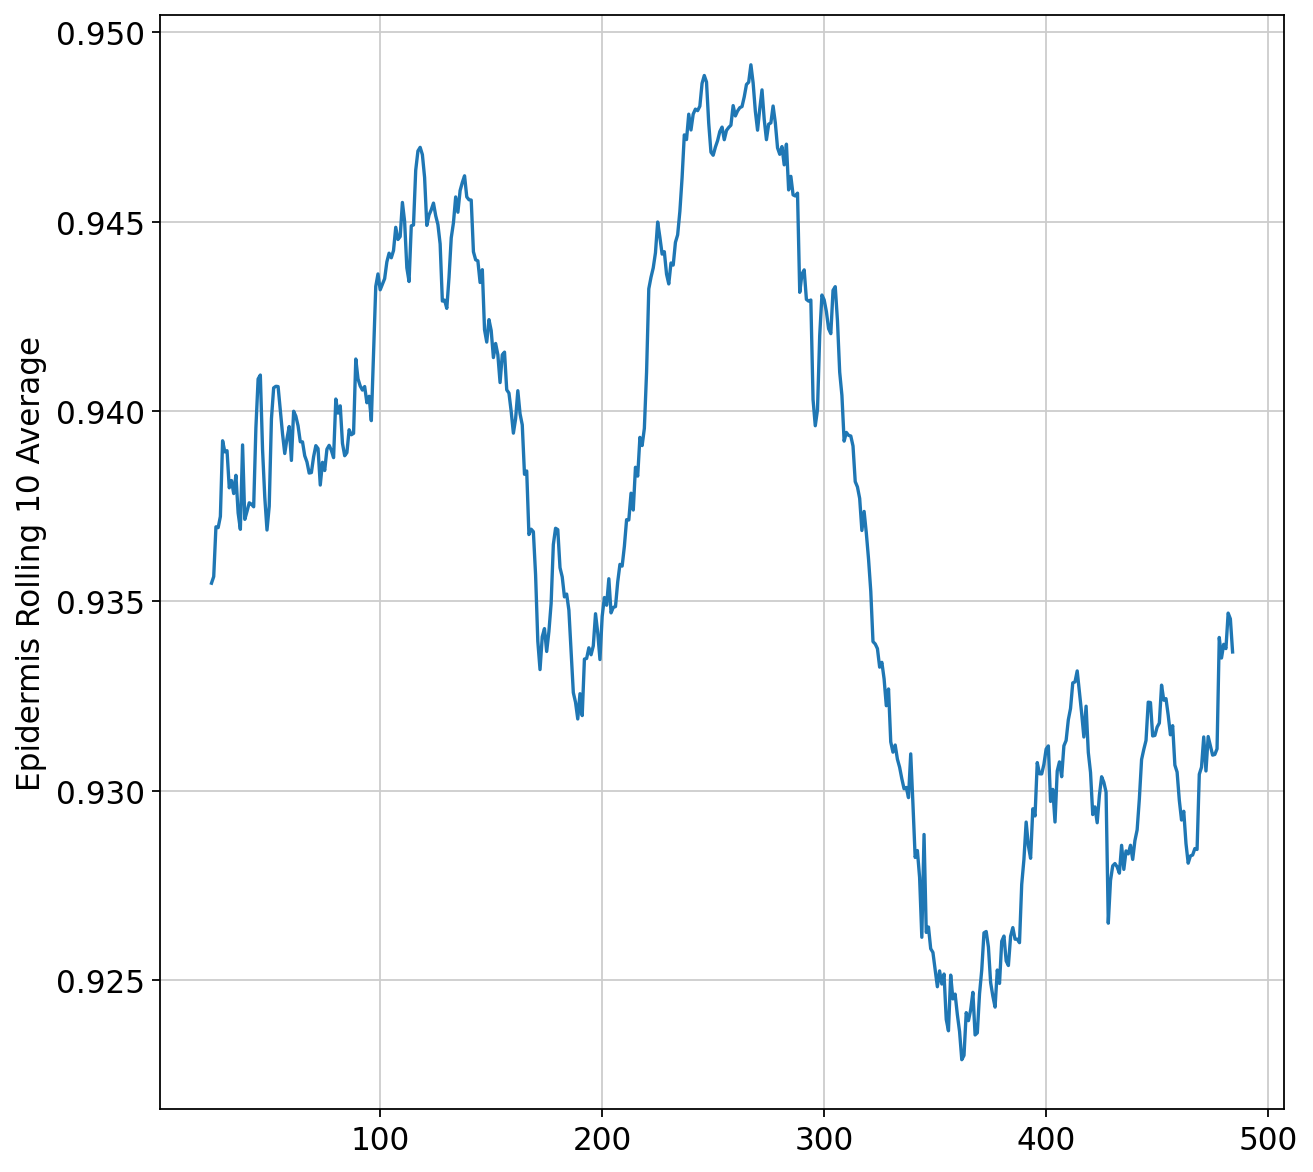

In [86]:
sns.lineplot(x = np.arange(510), y = cell_type_score_table['Epidermis Rolling 10 Average'])

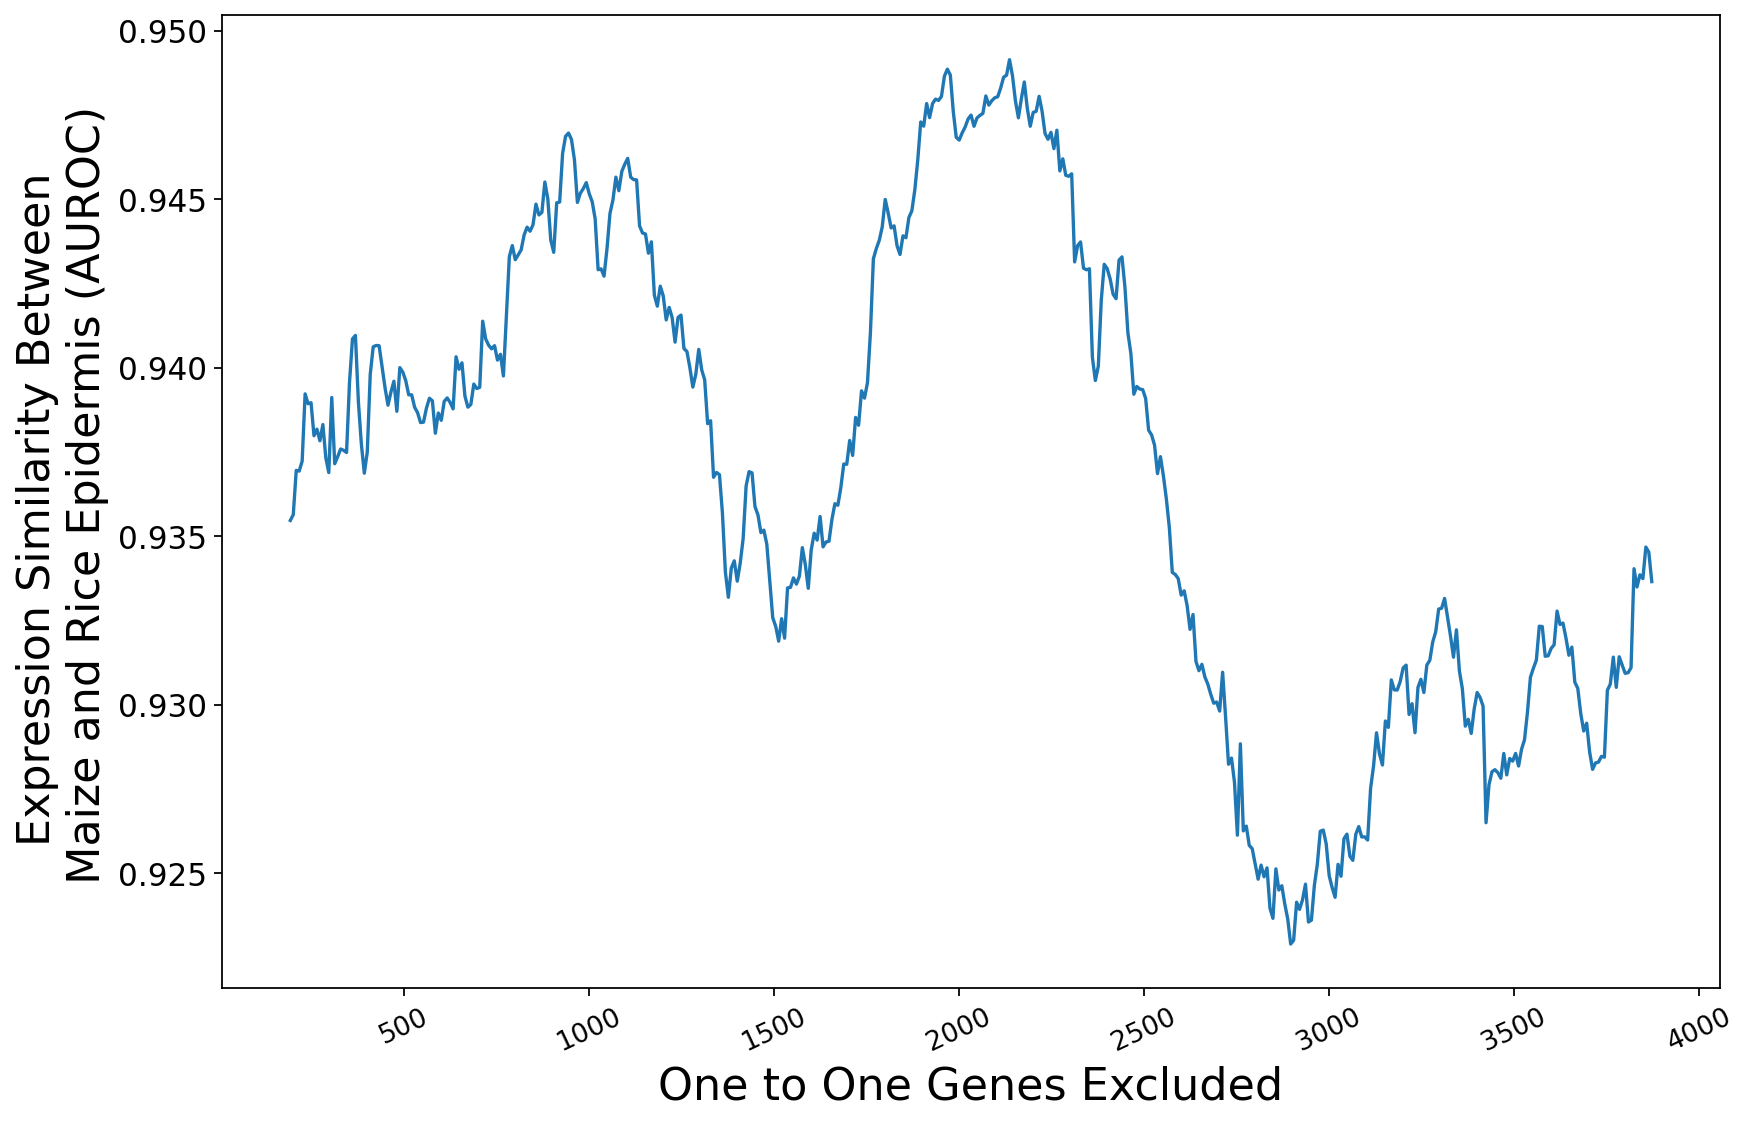

In [87]:
fig, ax = plt.subplots(figsize = (12,8))
fig.patch.set_facecolor('white')
ax = sns.lineplot(x = uno_to_uno_cells_excluded, y = cell_type_score_table['Epidermis Rolling 10 Average']) #style = 'Gene', dashes = True
plt.ylabel("Expression Similarity Between \n Maize and Rice Epidermis (AUROC)", fontsize = 20)
plt.xlabel("One to One Genes Excluded", fontsize = 20)
# sns.despine()

ax.grid(False)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
#ax.set_xticks([1,2,3,4], labels=['Epidermis','Stele','Cortex','Root Hair'])
#ax.set_xticklabels(['Phloem 1','Xylem','Endodermis 2','Phloem 2','Endodermis','Atrichoblasts/Columella','Trichoblasts','Meristematic/QC','Cortex'])
#plt.xlim((-7,7))
# plt.ylim((0, 1250))
#plt.title("Current Threshold is 31", fontsize = 20)
plt.xticks(fontsize = 12, rotation = 25)
#plt.yticks(fontsize = 11)
plt.savefig('/data/passala/Plots_for_projects/Coexpressolog_paper_plots/Epidermis_dropping_genes.svg')

In [88]:
cell_type_score_table['Root Hair Rolling 10 Average'] = cell_type_score_table['Root Hair'].rolling(50).mean().shift(-25)


<AxesSubplot:ylabel='Root Hair Rolling 10 Average'>

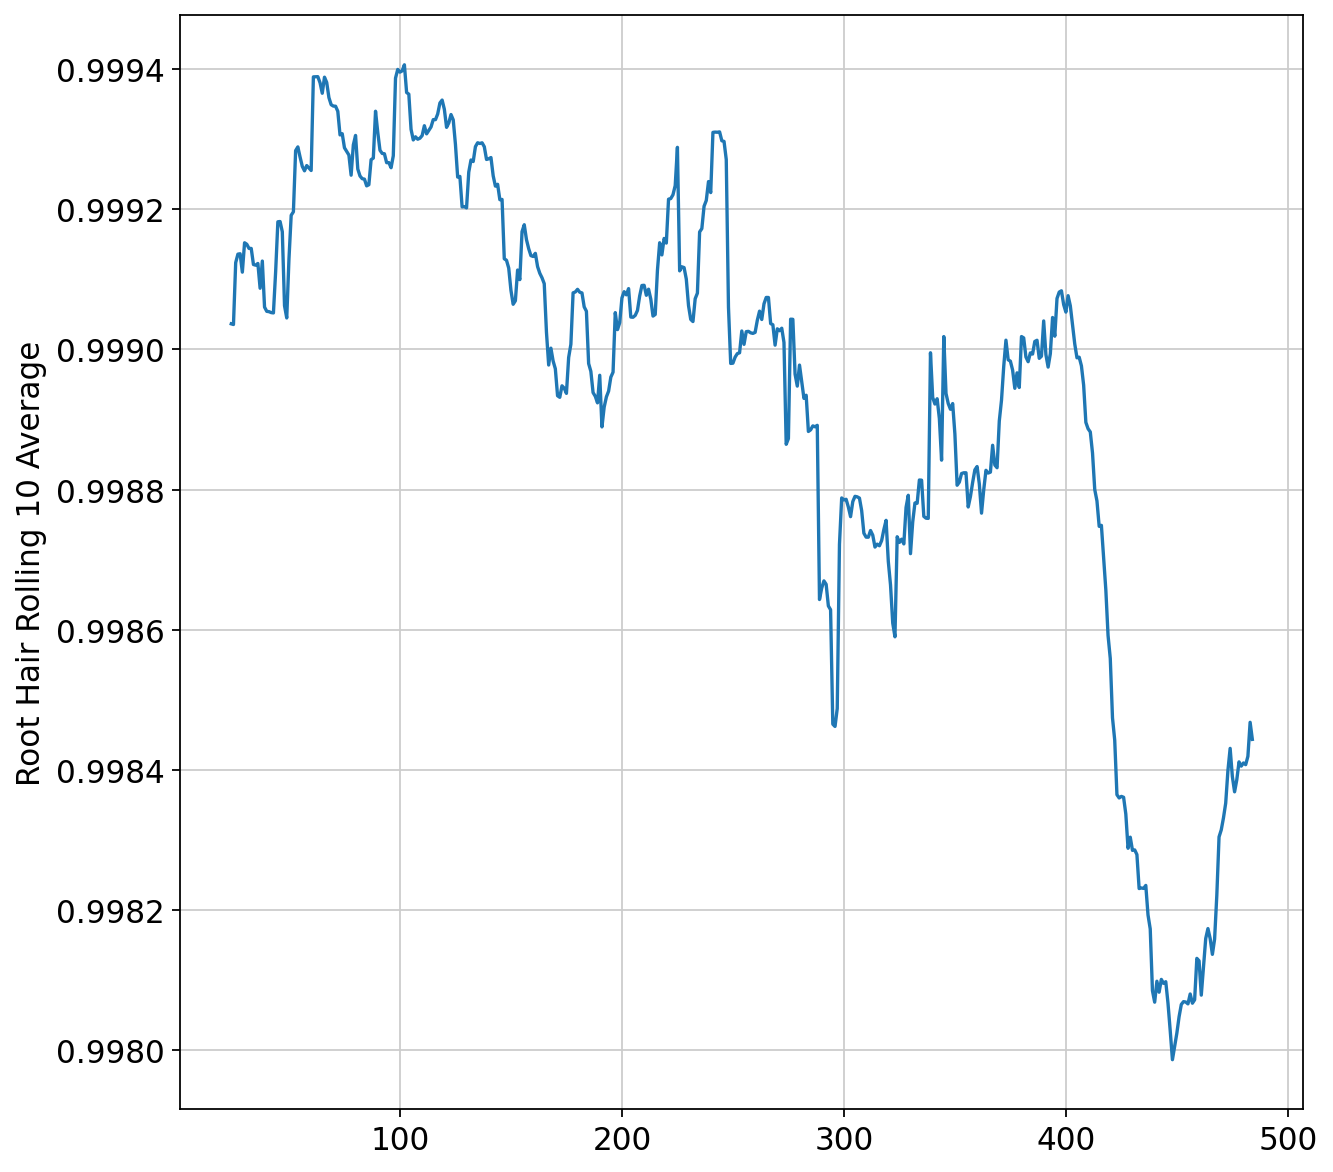

In [89]:
sns.lineplot(x = np.arange(510), y = cell_type_score_table['Root Hair Rolling 10 Average'])

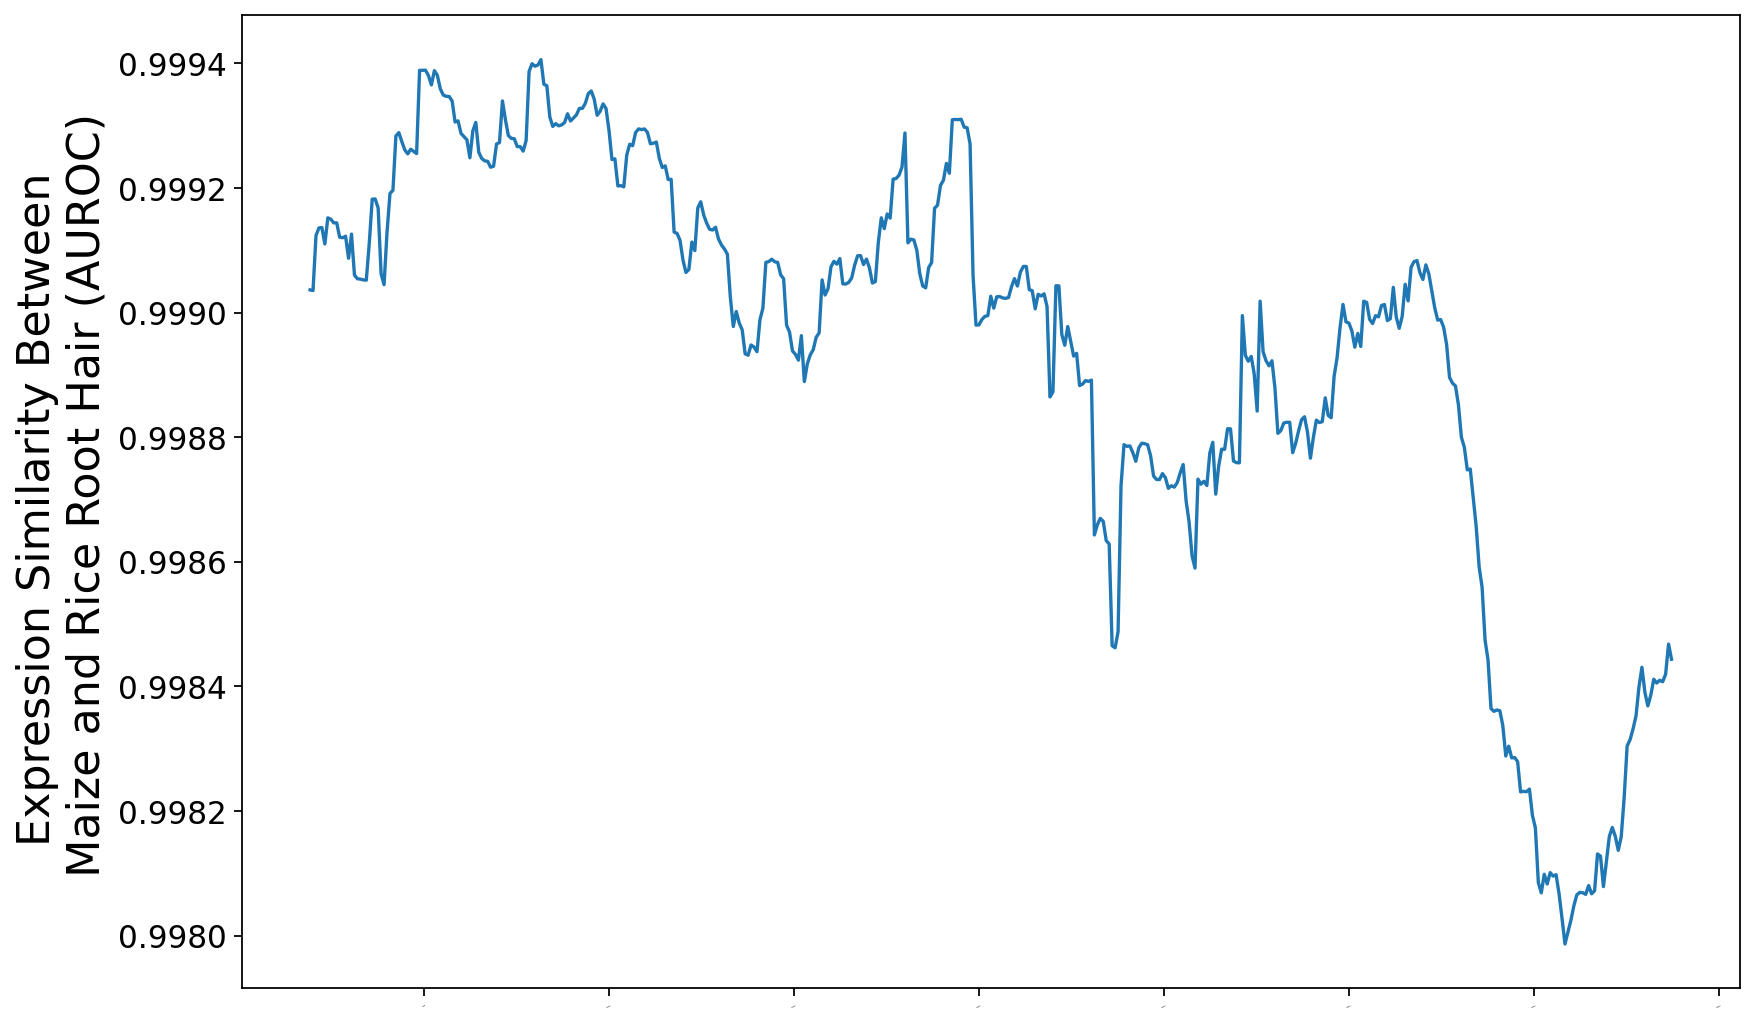

In [96]:
fig, ax = plt.subplots(figsize = (12,8))
fig.patch.set_facecolor('white')
ax = sns.lineplot(x = uno_to_uno_cells_excluded, y = cell_type_score_table['Root Hair Rolling 10 Average']) #style = 'Gene', dashes = True
plt.ylabel("Expression Similarity Between \n Maize and Rice Root Hair (AUROC)", fontsize = 20)
plt.xlabel("", fontsize = 20)
# sns.despine()

ax.grid(False)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
#ax.set_xticks([1,2,3,4], labels=['Epidermis','Stele','Cortex','Root Hair'])
#ax.set_xticklabels(['Phloem 1','Xylem','Endodermis 2','Phloem 2','Endodermis','Atrichoblasts/Columella','Trichoblasts','Meristematic/QC','Cortex'])
#plt.xlim((-7,7))
# plt.ylim((0, 1250))
#plt.title("Current Threshold is 31", fontsize = 20)
plt.xticks(fontsize = 0, rotation = 25)
#plt.yticks(fontsize = 11)
plt.savefig('/data/passala/Plots_for_projects/Coexpressolog_paper_plots/Root_hair_dropping_genes.svg')

In [80]:
cell_type_score_table['Cortex Rolling 10 Average'] = cell_type_score_table['Cortex'].rolling(50).mean().shift(-25)


<AxesSubplot:ylabel='Cortex Rolling 10 Average'>

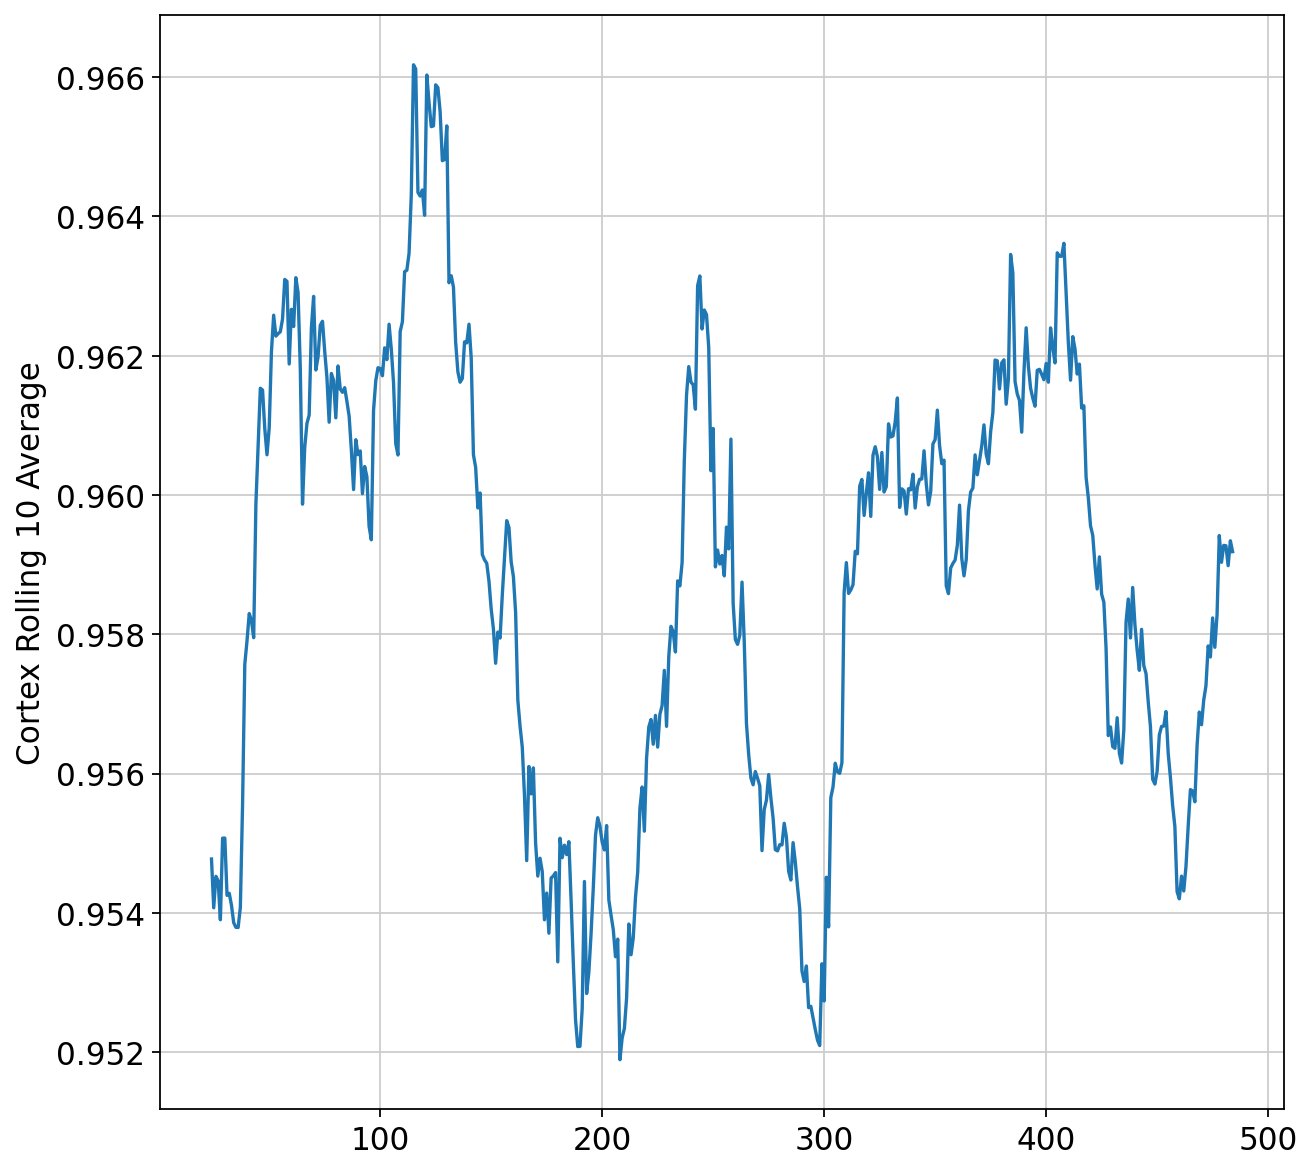

In [93]:
sns.lineplot(x = np.arange(510), y = cell_type_score_table['Cortex Rolling 10 Average'])

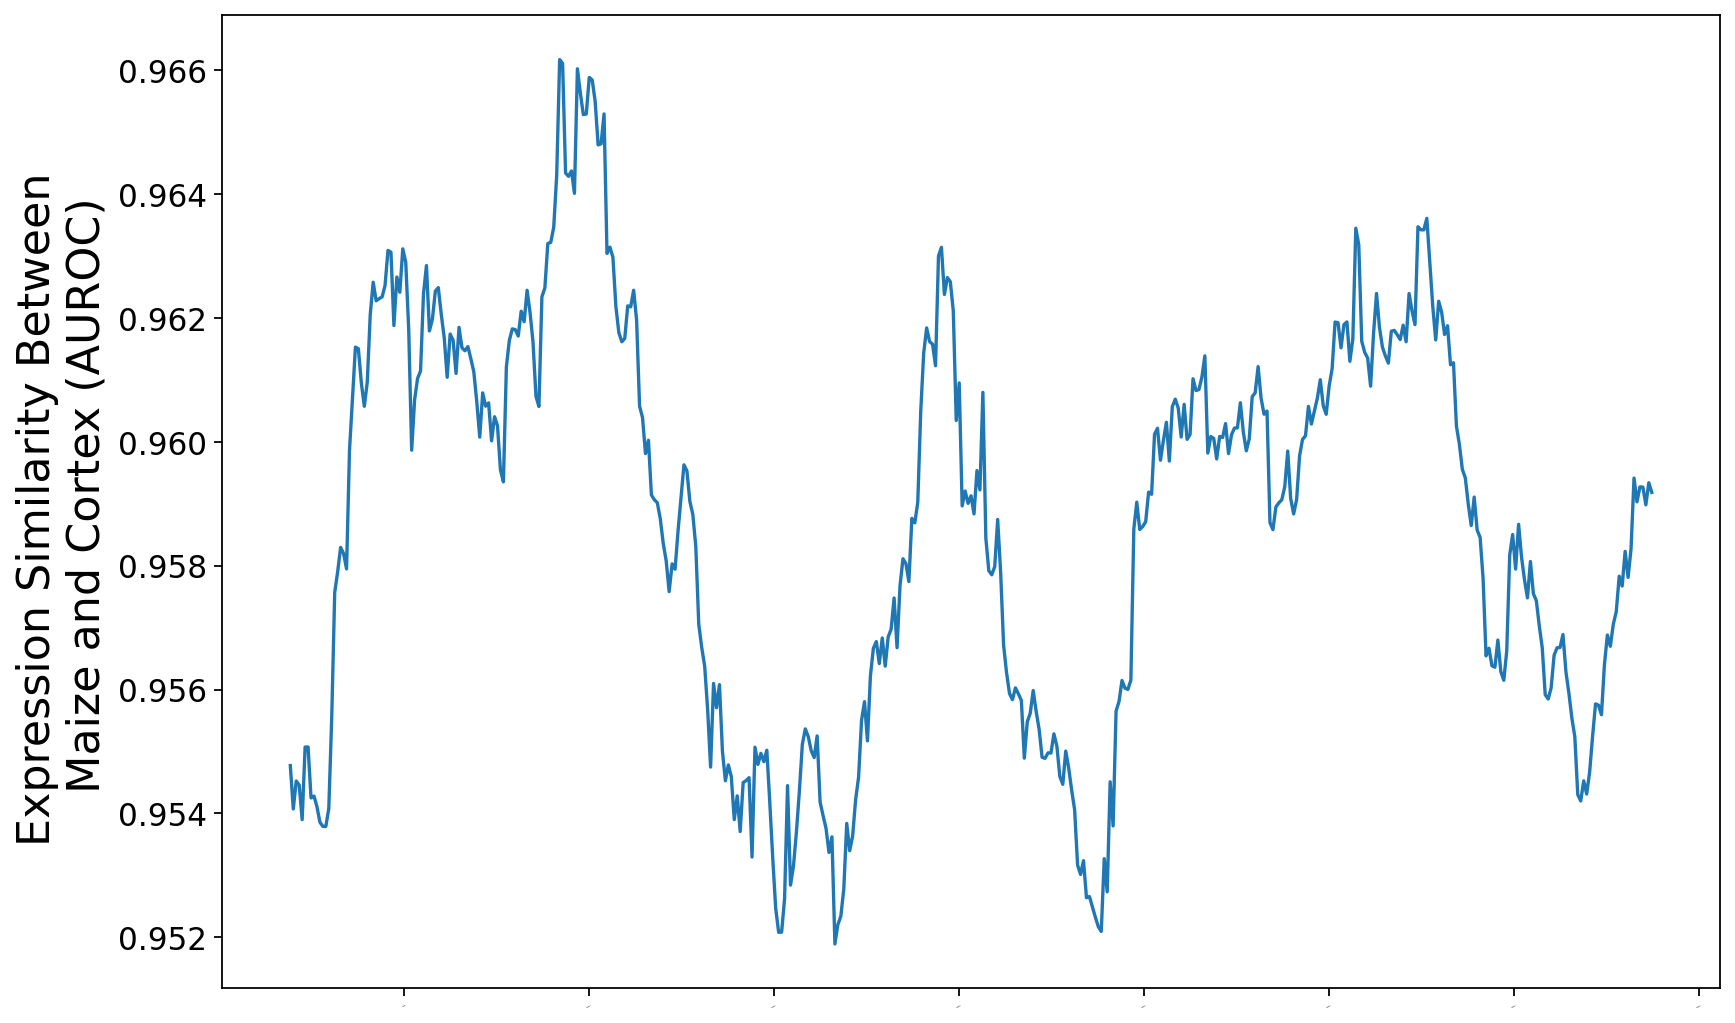

In [95]:
fig, ax = plt.subplots(figsize = (12,8))
fig.patch.set_facecolor('white')
ax = sns.lineplot(x = uno_to_uno_cells_excluded, y = cell_type_score_table['Cortex Rolling 10 Average']) #style = 'Gene', dashes = True
plt.ylabel("Expression Similarity Between \n Maize and Cortex (AUROC)", fontsize = 20)
plt.xlabel("", fontsize = 20)
# sns.despine()

ax.grid(False)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
#ax.set_xticks([1,2,3,4], labels=['Epidermis','Stele','Cortex','Root Hair'])
#ax.set_xticklabels(['Phloem 1','Xylem','Endodermis 2','Phloem 2','Endodermis','Atrichoblasts/Columella','Trichoblasts','Meristematic/QC','Cortex'])
#plt.xlim((-7,7))
# plt.ylim((0, 1250))
#plt.title("Current Threshold is 31", fontsize = 20)
plt.xticks(fontsize = 0, rotation = 25)
#plt.yticks(fontsize = 11)
plt.savefig('/data/passala/Plots_for_projects/Coexpressolog_paper_plots/cortex_dropping_genes.svg')

In [ ]:
tidy_table = tidy_table.rename(columns = {'variable':'Cell Type','value':'Average AUROC Across Species'})


In [ ]:
tidy_table

In [ ]:
fig, ax = plt.subplots(figsize = (15,12))
fig.patch.set_facecolor('white')
ax = sns.lineplot(data = tidy_table, x = 'Step',y = 'Average AUROC Across Species',hue = 'Cell Type')
plt.ylabel("Average AUROC Across Species", fontsize = 20)
plt.xlabel("Step", fontsize = 20)
sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
plt.title("Gradual Trend Towards Lower Quality As \n We Eliminate Genes", fontsize = 20)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

In [97]:
scgen.SCGEN.setup_anndata(concatendated_rice_maize_dataset, batch_key="Species", labels_key="Cell Cluster Annotation")


In [98]:
model = scgen.SCGEN(concatendated_rice_maize_dataset)

In [99]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=100 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|██▌       | 26/100 [04:50<13:46, 11.17s/it, loss=414, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1693.140. Signaling Trainer to stop.


In [102]:
concatendated_rice_maize_dataset

AnnData object with n_obs × n_vars = 14601 × 7189
    obs: 'n_genes', 'leiden', 'Cell Cluster Annotation', 'Species', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'Rice Gene', 'Maize Gene', 'n_cells-Maize', 'highly_variable-Maize', 'means-Maize', 'dispersions-Maize', 'dispersions_norm-Maize', 'highly_variable-Rice', 'means-Rice', 'dispersions-Rice', 'dispersions_norm-Rice', 'gene_ids-Rice', 'One to One'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'

In [100]:
corrected_adata = model.batch_removal()
corrected_adata

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


AnnData object with n_obs × n_vars = 14601 × 7189
    obs: 'n_genes', 'leiden', 'Cell Cluster Annotation', 'Species', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [101]:
pymn.variableGenes(corrected_adata,study_col = 'Species')
pymn.MetaNeighborUS(corrected_adata,study_col = 'Species',ct_col = 'Cell Cluster Annotation')

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/seaborn/matrix.py:1221: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


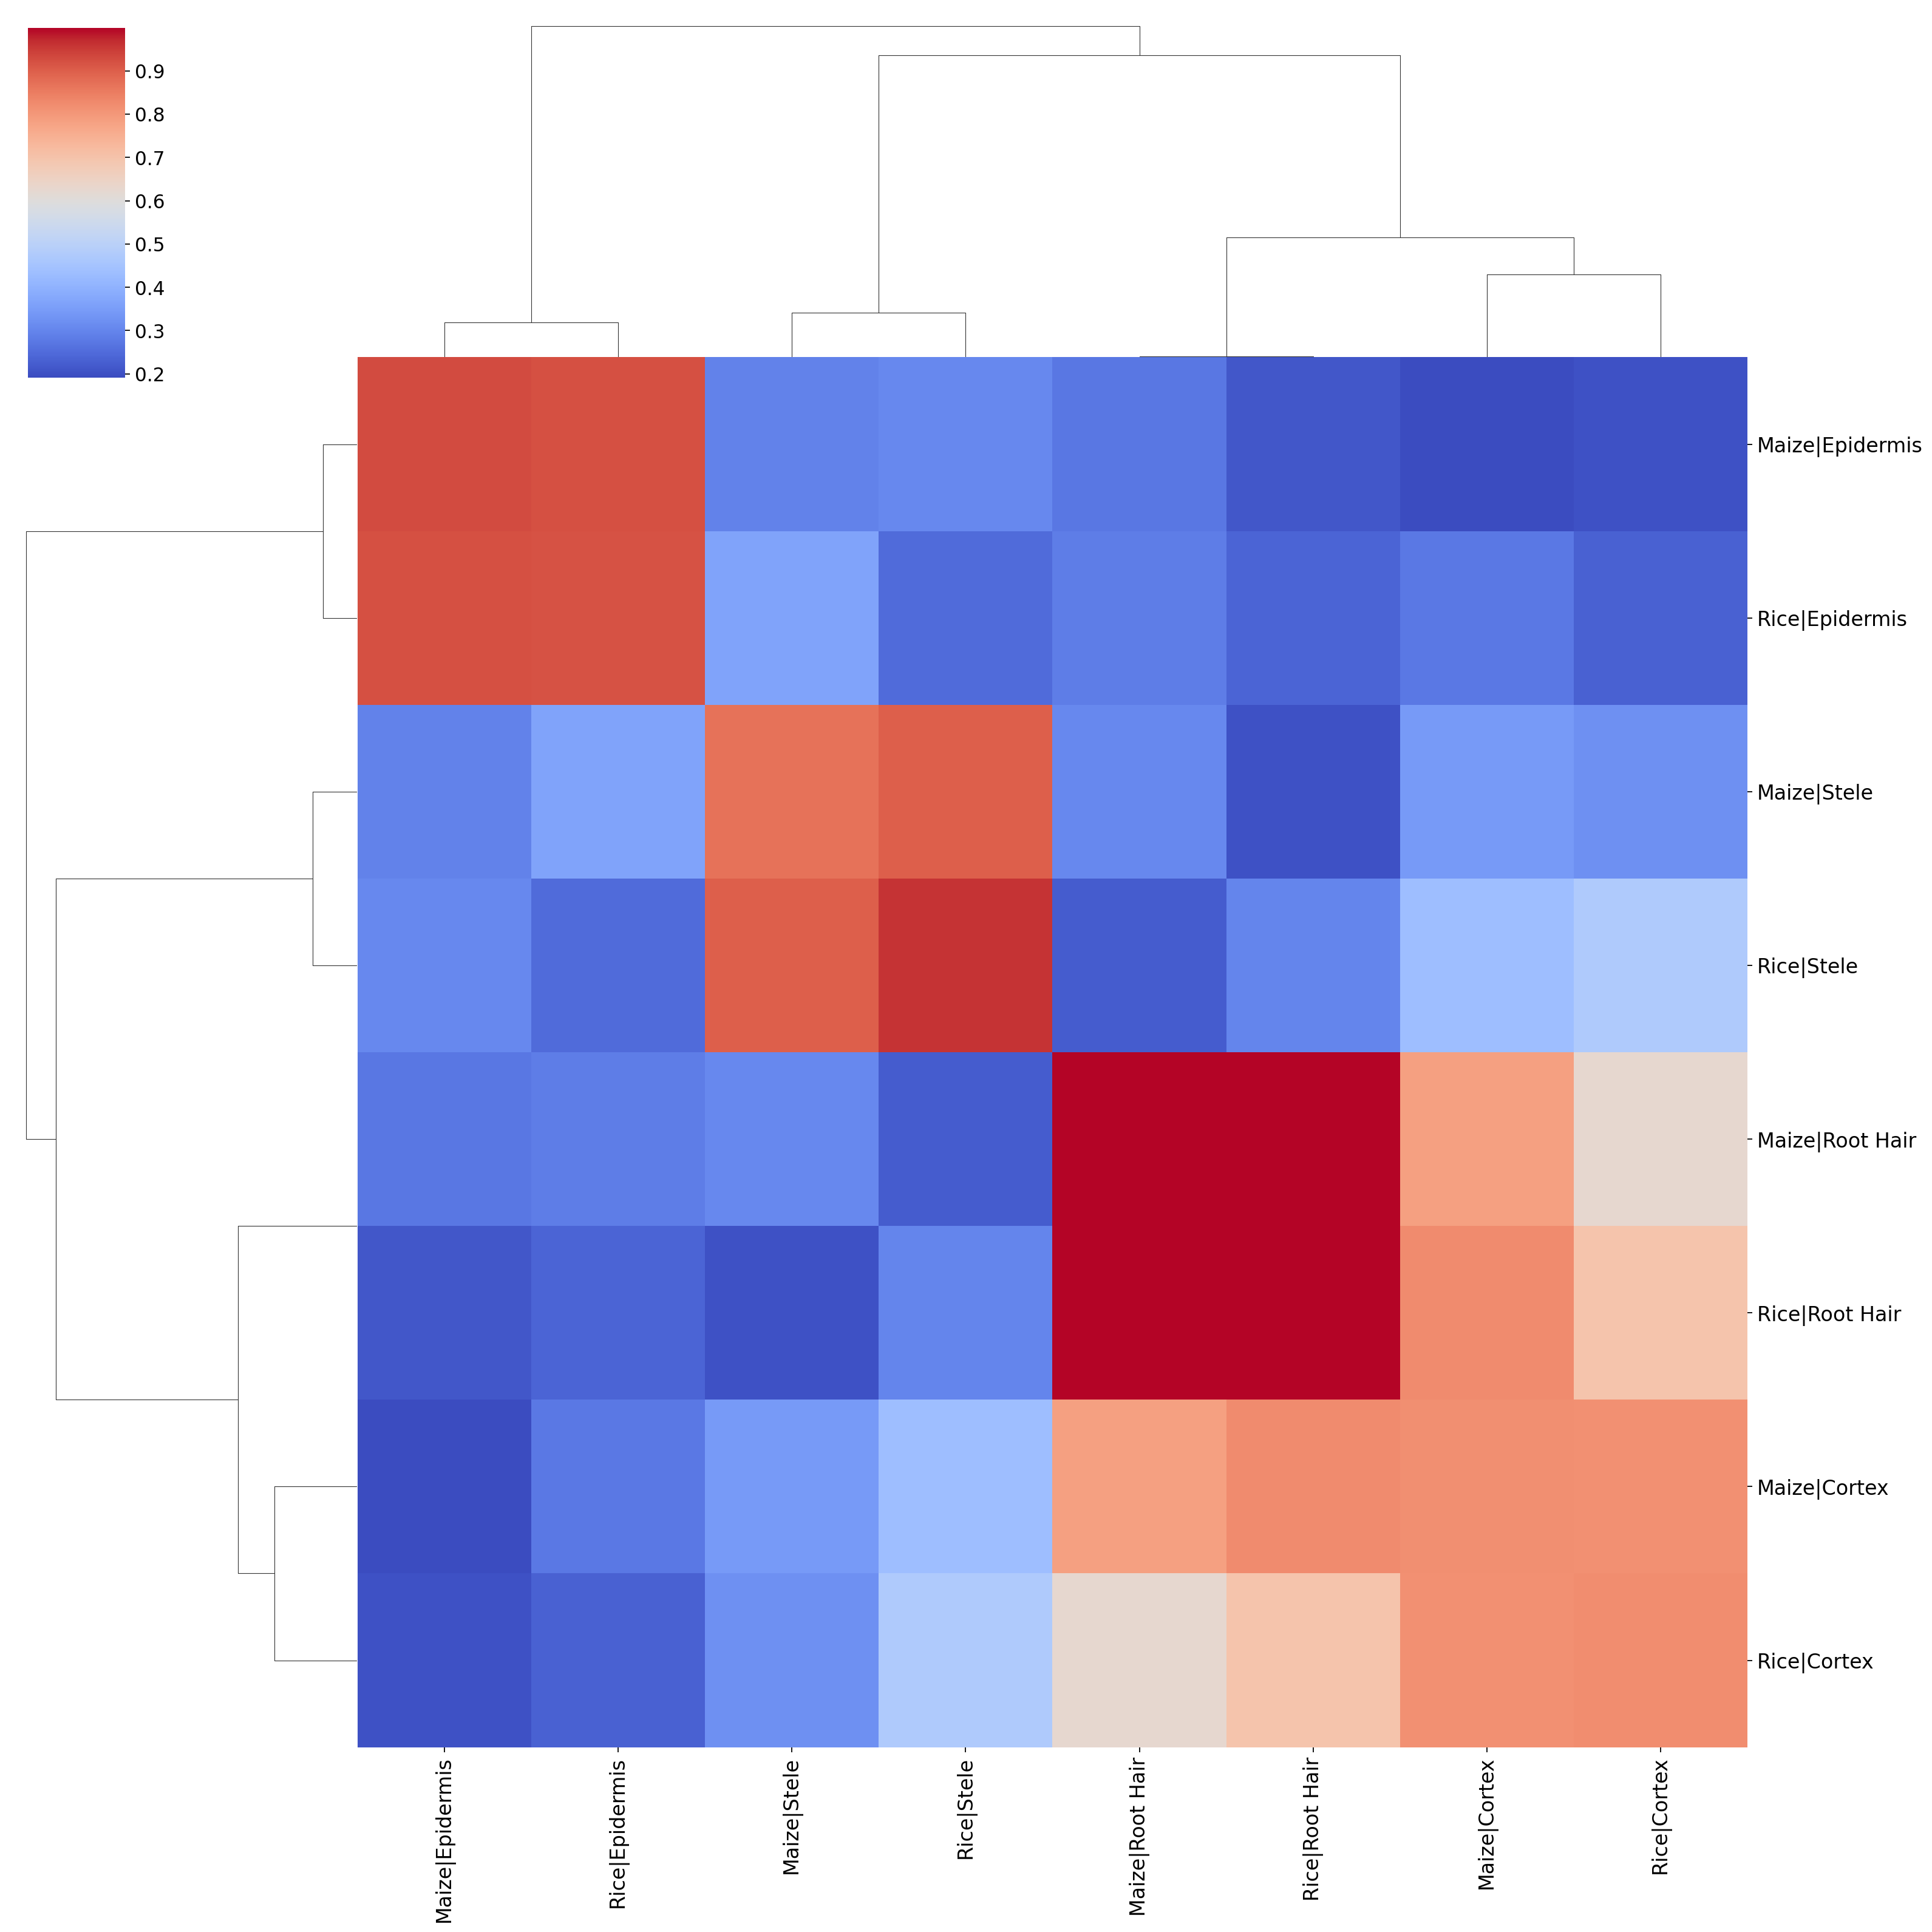

In [104]:
g = pymn.plotMetaNeighborUS(corrected_adata,figsize = (20,20),cmap = 'coolwarm',fontsize = 15,show = False,)